# De cañones y proyectiles

## Tiro oblicuo - Mecánica
<section class="post-meta">
Carlos Ruestes, Cristián Sánchez
</section>
Última edición: Noviembre de 2020


## Introducción
Uno de los clásicos problemas de la física es el de la determinación de la trayectoria de un proyectil sujeto a un campo gravitatorio uniforme. En la mayoría de los cursos iniciales de física, el abordaje de este problema se hace asumiendo que las fuerzas de fricción son despreciables (roce con el medio). Esto no es necesariamente así, en particular a altas velocidad. Si se considera a las fuerzas de fricción, la trayectoria del proyectil ya no puede ser descripta analíticamente y se deben utilizar técnicas de cálculo numérico. Para lograr esto, debemos resolver un conjunto de ecuaciones diferenciales acopladas, y esto nos ofrece una excelente oportunidad para implementar un solver para EDOs en forma vectorial. Como se verá a lo largo de este curso, la implementación se puede utilizar para resolver tanto ecuaciones diferenciales de orden superior como ecuaciones diferenciales acopladas.

## Teoría
### Ecuaciones de movimiento
Las ecuaciones que gobiernan la trayectoria de un proyectil se obtienen a partir de la segunda ley de Newton, $\vec{F} = m\vec{a}$, donde $\vec{F}$ es la fuerza actuante sobre el proyectil, $m$ es la masa, y $\vec{a}$ es la aceleración. En este ejemplo hay dos fuerzas actuantes sobre el proyectil. La fuerza gravitatoria 

$$\vec{F_G} = m\vec{g},$$

donde $\vec{g}$ denota la gravedad estándar. Y la otra fuerza que es la resistencia al avance (drag en inglés)

$$\vec{F_D} = -\frac{1}{2}\rho ACv_r^2\hat{v_r}.$$ 

$A$ es la sección transversal del móvil, $C$ es el coeficiente de resistencia (¿Por qué no lo llamo coeficiente de fricción?), y $v_r$ es la velocidad del proyectil relativa al fluido en el que se desplaza, $\rho$ es la densidad del aire y $\hat{v_r}$ es la dirección del proyectil, como vector unitario. Una forma más práctica de escribir esta ecuación es 

$$\vec{F_D} = - \frac{B}{\rho_0}\rho v_r\left(\vec{v}-\vec{V}\right),$$

donde $\rho_0$ es la densidad del aire a nivel del mar, $B$ es una constante, $\vec{v}$ es la velocidad del proyectil, y $\vec{V}$ es la velocidad del viento. 

En este ejemplo, utilizaremos valores realistas, correspondiente a las balas utilizadas por el arma alemana "Cañon de Paris", y las constantes numéricas mencionadas anteriormente fueron tomadas de datos históricos. El cañon de Paris operó durante la Primera Guerra Mundial y bombardeó Paris desde distancias que a menudo excedían los 100 kilómetros. Estos alcances solo podían obtenerse mediante altas velocidades de proyectil.

La última parte de la teoría necesaria, antes de obtener las ecuaciones de movimiento, es una expresión para la densidad del aire. La misma varía con la altura. Siendo que las balas del cañon pueden alcanzar grandes alturas, no es razonable tratar a $\rho$ como una constante. Por lo tanto utilizaremos un modelo adiabático para la densidad de aire dado por la expresión 

$$\rho = \rho_0 \left(1 - \frac{ay}{T_0}\right)^\alpha,$$

donde $\rho$ y $T_0$ denotan la densidad y temperatura del aire a nivel del mar, $y$ denota la altitud, $a$ y $\alpha$ son constantes $a= 6.5 \cdot 10^{-3}$ K/m, $\alpha$ = 2.5. A muy altas altitudes, la expresión entre paréntesis se hace negativa, tornando a la densidad en un número complejo con parte imaginaria no nula. Para evitar esto, la densidad del aire se considera 0 cuando alcanza dichas altitudes. Esta altura crítica es de alrededor de 44 kilómetros, correspondiente a la estratósfera.  

En un sistema de coordenadas bidimensional, donde $x$ e $y$ son desplazamientos desde el origen y en dirección horizontal y vertical respectivamente, las ecuaciones de movimiento resultan 
$$
\begin{align}
m\ddot{x} &= -\frac{B}{\rho_0}\rho\left(\dot{x}-V_x\right)\left|\vec{v}-\vec{V}\right|,\\
m\ddot{y} &= -\frac{B}{\rho_0}\rho\left(\dot{y}-V_y\right)\left|\vec{v}-\vec{V}\right|-mg,
\end{align}
$$


donde $V_x$ y $V_y$ denotan la velocidad del viento en dirección horizontal y vertical. Simplificando aún más, y escribiendo como $u$ y $v$ a las velocidades en dirección horizontal y vertical, lo que nos da un sistema de ecuaciones diferenciales acopladas

\begin{equation}
\begin{aligned}
\dot{x} &= u, \\
\dot{u} &= -\frac{B}{m}\Big[ 1 - \frac{ay}{T_0} \Big]^\alpha \left(u-V_x\right)\Big[ (u-V_x)^2+(v-V_y)^2 \Big]^{1/2},\\
\dot{y} &= w, \\
\dot{w} &= -\frac{B}{m}\Big[ 1 - \frac{ay}{T_0} \Big]^\alpha \left(v-V_y\right)\Big[ (u-V_x)^2+(v-V_y)^2 \Big]^{1/2}-g.\\
\end{aligned}
\label{ODEs}
\end{equation}

### Discretización: Runge-Kutta de 4to orden

Definamos primero un conjunto discreto de $N$ valores temporales $$
t_n=t_0+n\cdot h~~~~~\mathrm{with}~~~~n=0,1,2,3,...,N.
$$

$h$ es la longitud del paso de tiempo y se calcula mediante la fórmula $h = \frac{t_N-t_0}{N}$, donde $t_0$ y $t_N$ denotan los valores de tiempo final e inicial del vuelo del proyectil. Estos $N$ valores de tiempo corresponden a $N$ valores de $x$, $y$, $u$, y $w$, cada uno denominado $x_n$, $y_n$, $u_n$ y $w_n$. Un modo más práctico de escribir este conjunto de valores es en forma vectorial
$$
\vec{w_n} = \begin{bmatrix}x_n \\ y_n \\ u_n \\ v_n\end{bmatrix}.
$$

Esta notación hace posible implementar el método de Runge-Kutta. Resulta posible reducir una ecuación diferencial ordinaria de orden $q$ a un problema donde se resuelve un conjunto de dos ecuaciones diferenciales de orden $q-1$ acopladas. En nuestro caso tenemos un conjunto de dos ecuaciones diferenciales de segundo orden, por lo que podemos resolverlas como un conjunto de cuatro ecuaciones diferenciales de primer orden acopladas. Introduciendo una función  $f$ que transforma $\vec{w_n}$ en la forma descripta por la ecuación descripta en \eqref{ODEs}, se puede implementar el método de Runge-Kutta directamente. En nuestro caso, $f$ viene dada por

$$
f(\vec{w_n} ) = f \begin{bmatrix}x_n \\ y_n \\ u_n \\ v_n\end{bmatrix} = \begin{bmatrix}u_n \\ v_n \\ -\frac{B}{m}\Big[ 1 - \frac{ay_n}{T_0} \Big]^\alpha \left(u_n-V_x\right)\Big[ (u_n-V_x)^2+(v_n-V_y)^2 \Big]^{1/2} \\ -\frac{B}{m}\Big[ 1 - \frac{ay_n}{T_0} \Big]^\alpha \left(v_n-V_y\right)\Big[ (u_n-V_x)^2+(v_n-V_y)^2 \Big]^{1/2}-mg\end{bmatrix},
$$
sin dependencia del tiempo, de forma tal que 
$$
\dot{\vec{w_n}}=f(\vec{w_n})
$$

describe completamente el sistema de ecuaciones diferenciales. El siguiente código implementa esto, y podríamos expandirlo ya sea para solucionar una EDO de orden superior o una EDO de un problema tri-dimensional. 


## Implementación

In [1]:
# Importar paquetes necesarios
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

newparams = {'figure.figsize': (15, 7), 'axes.grid': False,
             'lines.markersize': 10, 'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral', 'figure.dpi': 200}
plt.rcParams.update(newparams)

# Constantes

g = 9.81             # Fuerza gravitatoria
alpha = 2.5          # Parametro en el modelo de densidad
a = 6.5 * 10 ** (-3) # Parametro en el modelo de densidad
T_0 = 288            # Temperatura a nivel del mar
m = 50               # Masa del proyectil
B = 2 * 10 ** (-3)   # Constante del cañon de Paris
v_0 = 1640           # Velocidad inicial


# Velocidad del viento. Considerada constante 
V = np.zeros(2) # Comenzando sin viento


def f(w):
    """ Una función que describe el lado derecho de las ecuaciones
    de movimiento / conjunto de EDOs.
    Parametro:
        w       vector que contiene las coordenadas y velocidades necesarias 
    """
    # V : el vector que describe la velocidad del viento y direccion
    temp_vector = np.zeros(4)
    temp_vector[0] = w[2]
    temp_vector[1] = w[3]
    # Guardando parametros siguientes para optimizar tiempos de calculo
    k = (1 - a * w[1] / T_0)   # Densidad del aire
    s = np.sqrt((w[2]-V[0]) ** 2 + (w[3]-V[1]) ** 2 )
    if k>0:
        temp_vector[2] = - B / m * k ** (alpha) * (w[2]-V[0]) * s
        temp_vector[3] = - B / m * k ** (alpha) * (w[3]-V[1]) * s - g
    else:
        temp_vector[2] = 0 
        temp_vector[3] = - g
    return temp_vector 


def RK4_step(f, w, h):
    """Realizar un paso del metodo de Runge-Kutta 4to orden.
    Parametros:
        f      Lado derecho de las EDOs a integrar
        w      aproximación numérica de w a tiempo t
        h      unidad/longitud del paso de integración
    Devuelve:
        aproximación numérica de w a tiempo t+h
    """
    s1 = f(w)
    s2 = f(w + (h / 2) * s1)
    s3 = f(w + (h / 2) * s2)
    s4 = f(w + h * s3)
    return w + (h / 6) * (s1 + (2 * s2) + (2 * s3) + s4)

Ahora podemos comenzar a explorar las trayectorias del cañon de Paris. La función que aparece debajo será útil a medida que avancemos. 

In [2]:
def shoot(theta, v0):
    """ Inicializar el vector w (posición x e y y velocidad del
    proyectil) dado un angulo inicial del tiro, theta, y velocidad 
    con modulo, v0. 
    """
    w = np.zeros(4)
    w[2] = v0 * np.cos(np.deg2rad(theta))
    w[3] = v0 * np.sin(np.deg2rad(theta))
    return w


def projectile_motion(h, theta):
    """ Calcula el movimiento del proyectil usando las funciones
    definidas abajo. Mientras el proyectil esta en el aire (w[1] >=0) la 
    posicion y velocidad se actualizan usando un solo paso de RK4.
    Parametros:
        h        longitud del paso de integracion
        theta    angulo de tiro inicial
    Devuelve:
        X_list   arreglo de coordenadas x del proyectil
        Y_list   arreglo de coordenadas y del proyectil
    """
    w = shoot(theta, v_0)
    X_list = np.zeros(0)
    Y_list = np.zeros(0)
    while  w[1] >= 0:
        w = RK4_step(f, w, h)
        X_list = np.append(X_list, w[0])
        Y_list = np.append(Y_list, w[1])
    return X_list, Y_list

### Encontrando el ángulo de tiro óptimo
En ausencia de resistencia al avance, es sabido que el ángulo que maximiza el alcance es $\theta = 45^\circ$, donde $\theta$ es el ángulo entre el eje horizontal y la dirección del vector velocidad inicial. Es interesante ver como la resistencia al avance que ofrece el aire afecta al ángulo de tiro y su correspondiente alcance, tanto con viento como sin viento. El siguiente código encuentra el ángulo óptimo con una precisión de un decimal, y muestra como el alcance depende del ángulo de tiro.  

In [3]:
def find_optimal_angle(h):
    """ Dado un paso de integración, esta funcion calcula el angulo de tiro  inicial 
    optimo para que el proyectil obtenga alcance maximo en direccion x. Se devuelve el 
    conjunto de angulos probados, su correspondiente alcance, junto con el angulo 
    optimo.
    """
    
    record = 0        # Aca guardaremos el maximo alcance
    optimal_angle = 0 # Aca guardaremos el angulo que permite obtener el mismo
    # Lista conteniendo el angulo inicial y su correspondiente rango. 
    theta_list = np.zeros(0) 
    range_list = np.zeros(0)
    for theta in range (1,90,2):
        x_list, y_list = projectile_motion(h, theta)
        # Usando interpolación lineal, determinar el punto de aterrizaje
        m = (y_list[-1] - y_list[-2]) / (x_list[-1] - x_list[-2])   # Punto de aterrizaje
        x_range = - y_list[-1] / m + x_list[-1] 
        theta_list = np.append(theta_list, theta)
        range_list = np.append(range_list, x_range)
        # Actualizar registros
        if x_range >= record:
            record = x_range
            optimal_angle = theta

    # Correr de nuevo el codigo con intervalo menor para aproximar el angulo optimo con mayor
    # precision
    theta_list_smaller = np.linspace(optimal_angle - 2, optimal_angle + 2, 41)
    for theta_small in theta_list_smaller:
        x_list, y_list = projectile_motion(h, theta)
        # Nuevamente, usar interpolacion lineal para determinar el punto de aterrizaje
        m = (y_list[-1] - y_list[-2]) / (x_list[-1] - x_list[-2])
        x_range = - y_list[-1] / m + x_list[-1]
        if x_range >= record:
            record = x_range
            optimal_angle = theta_small
            
    return theta_list, range_list, optimal_angle

theta, x , best = find_optimal_angle(0.1)

print("El angulo optimo es: ", best, " grados")

El angulo optimo es:  55  grados


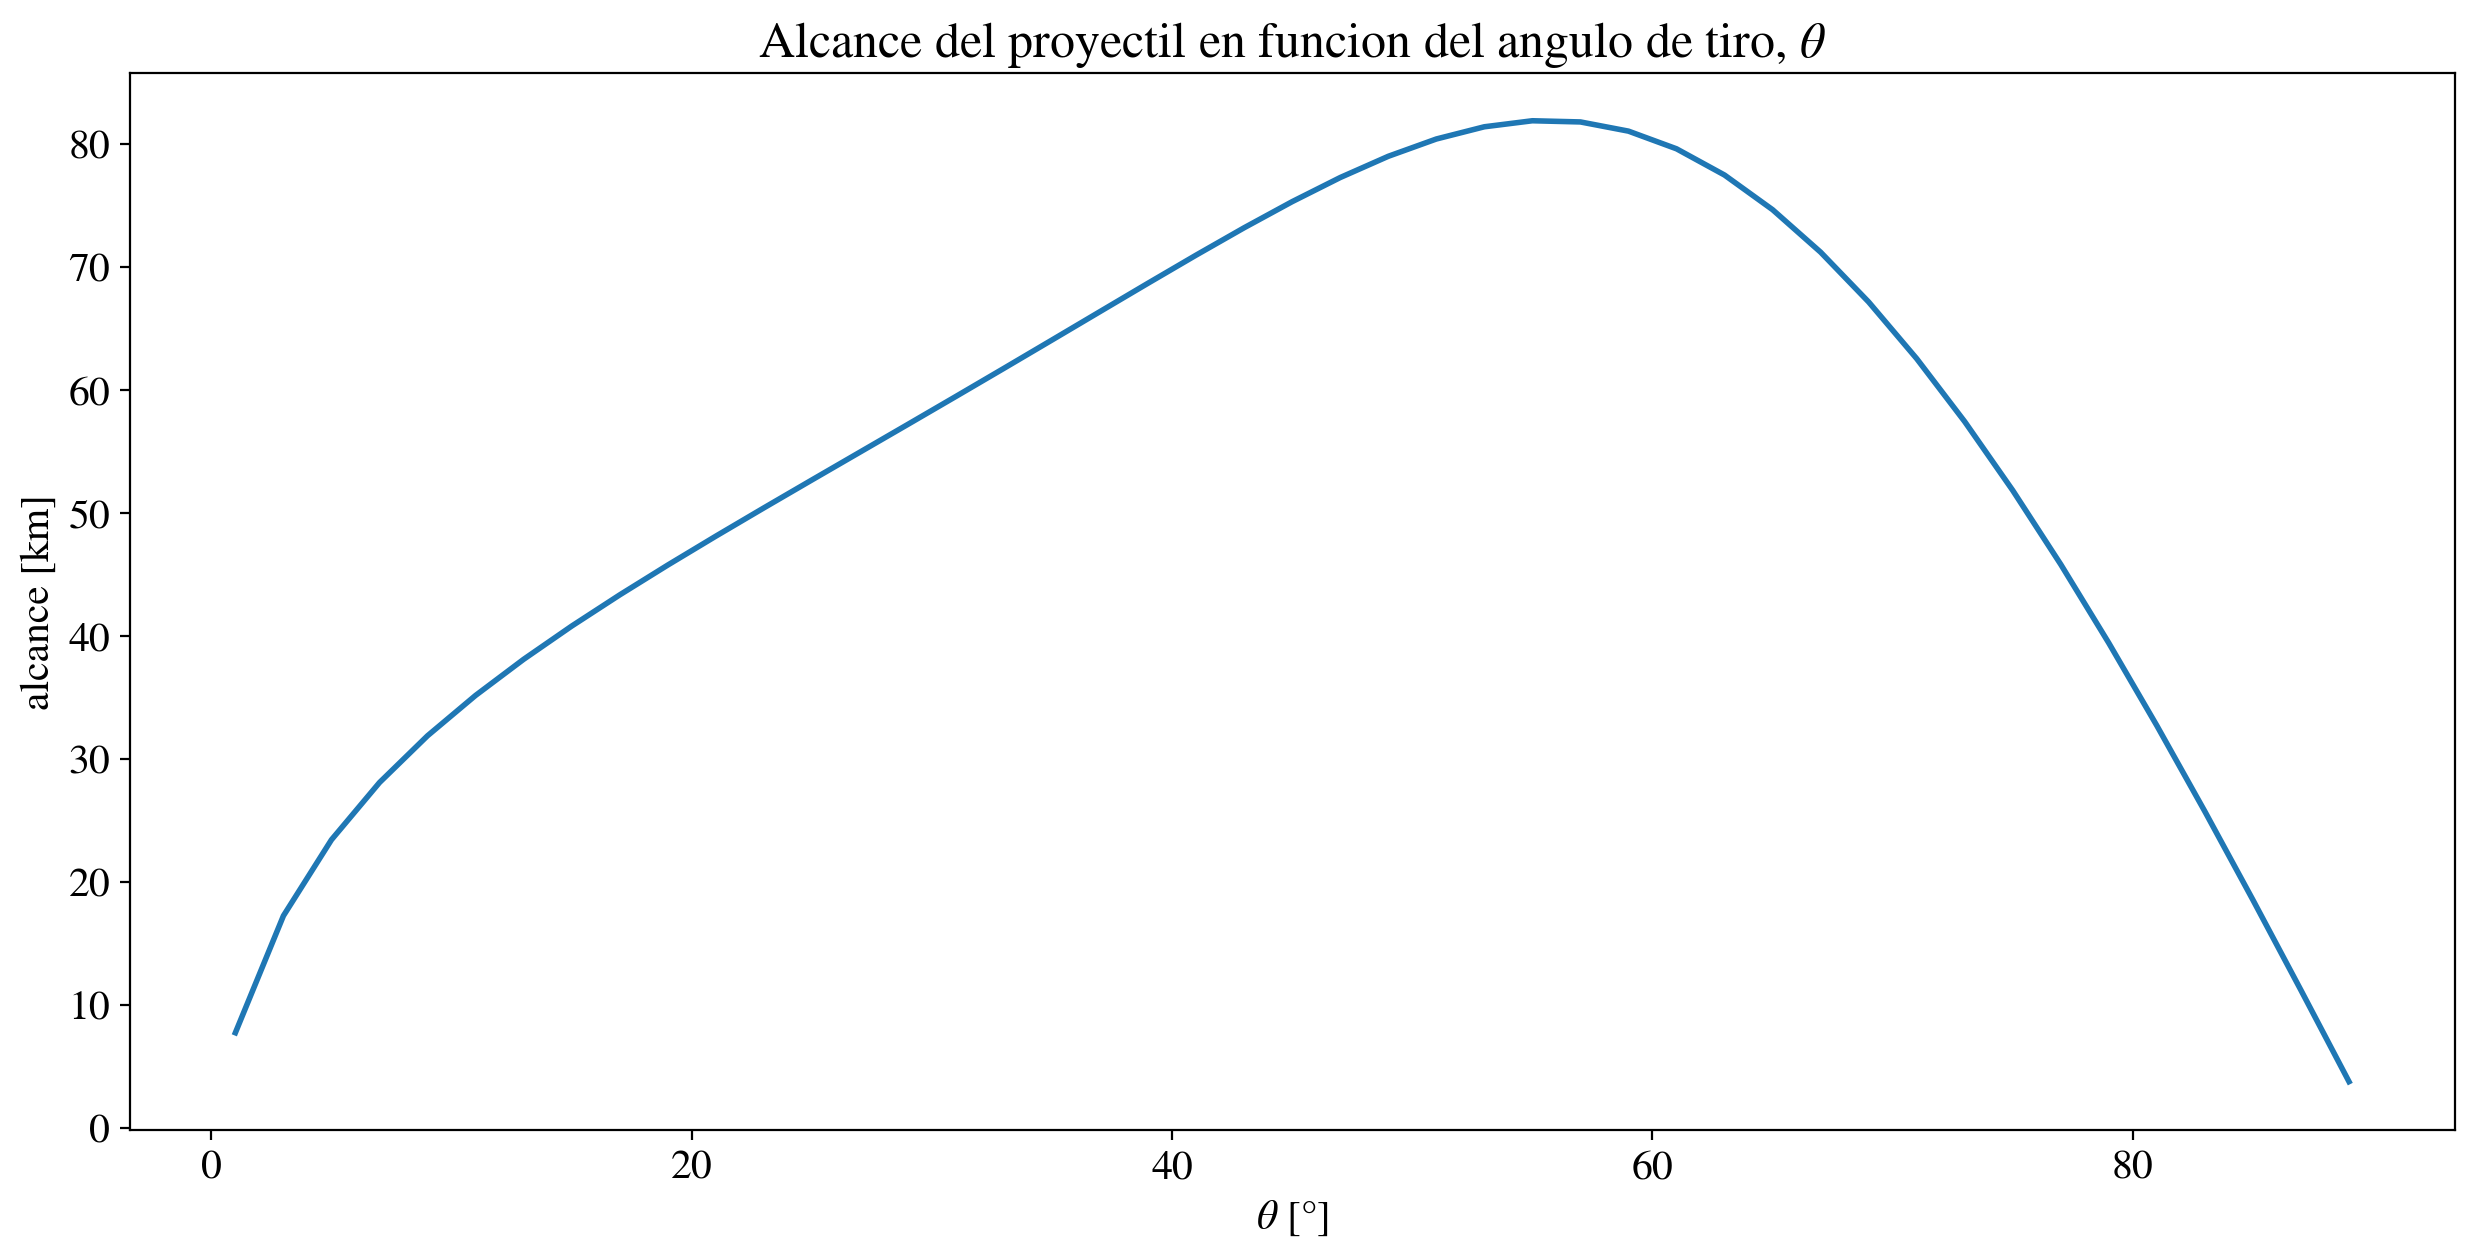

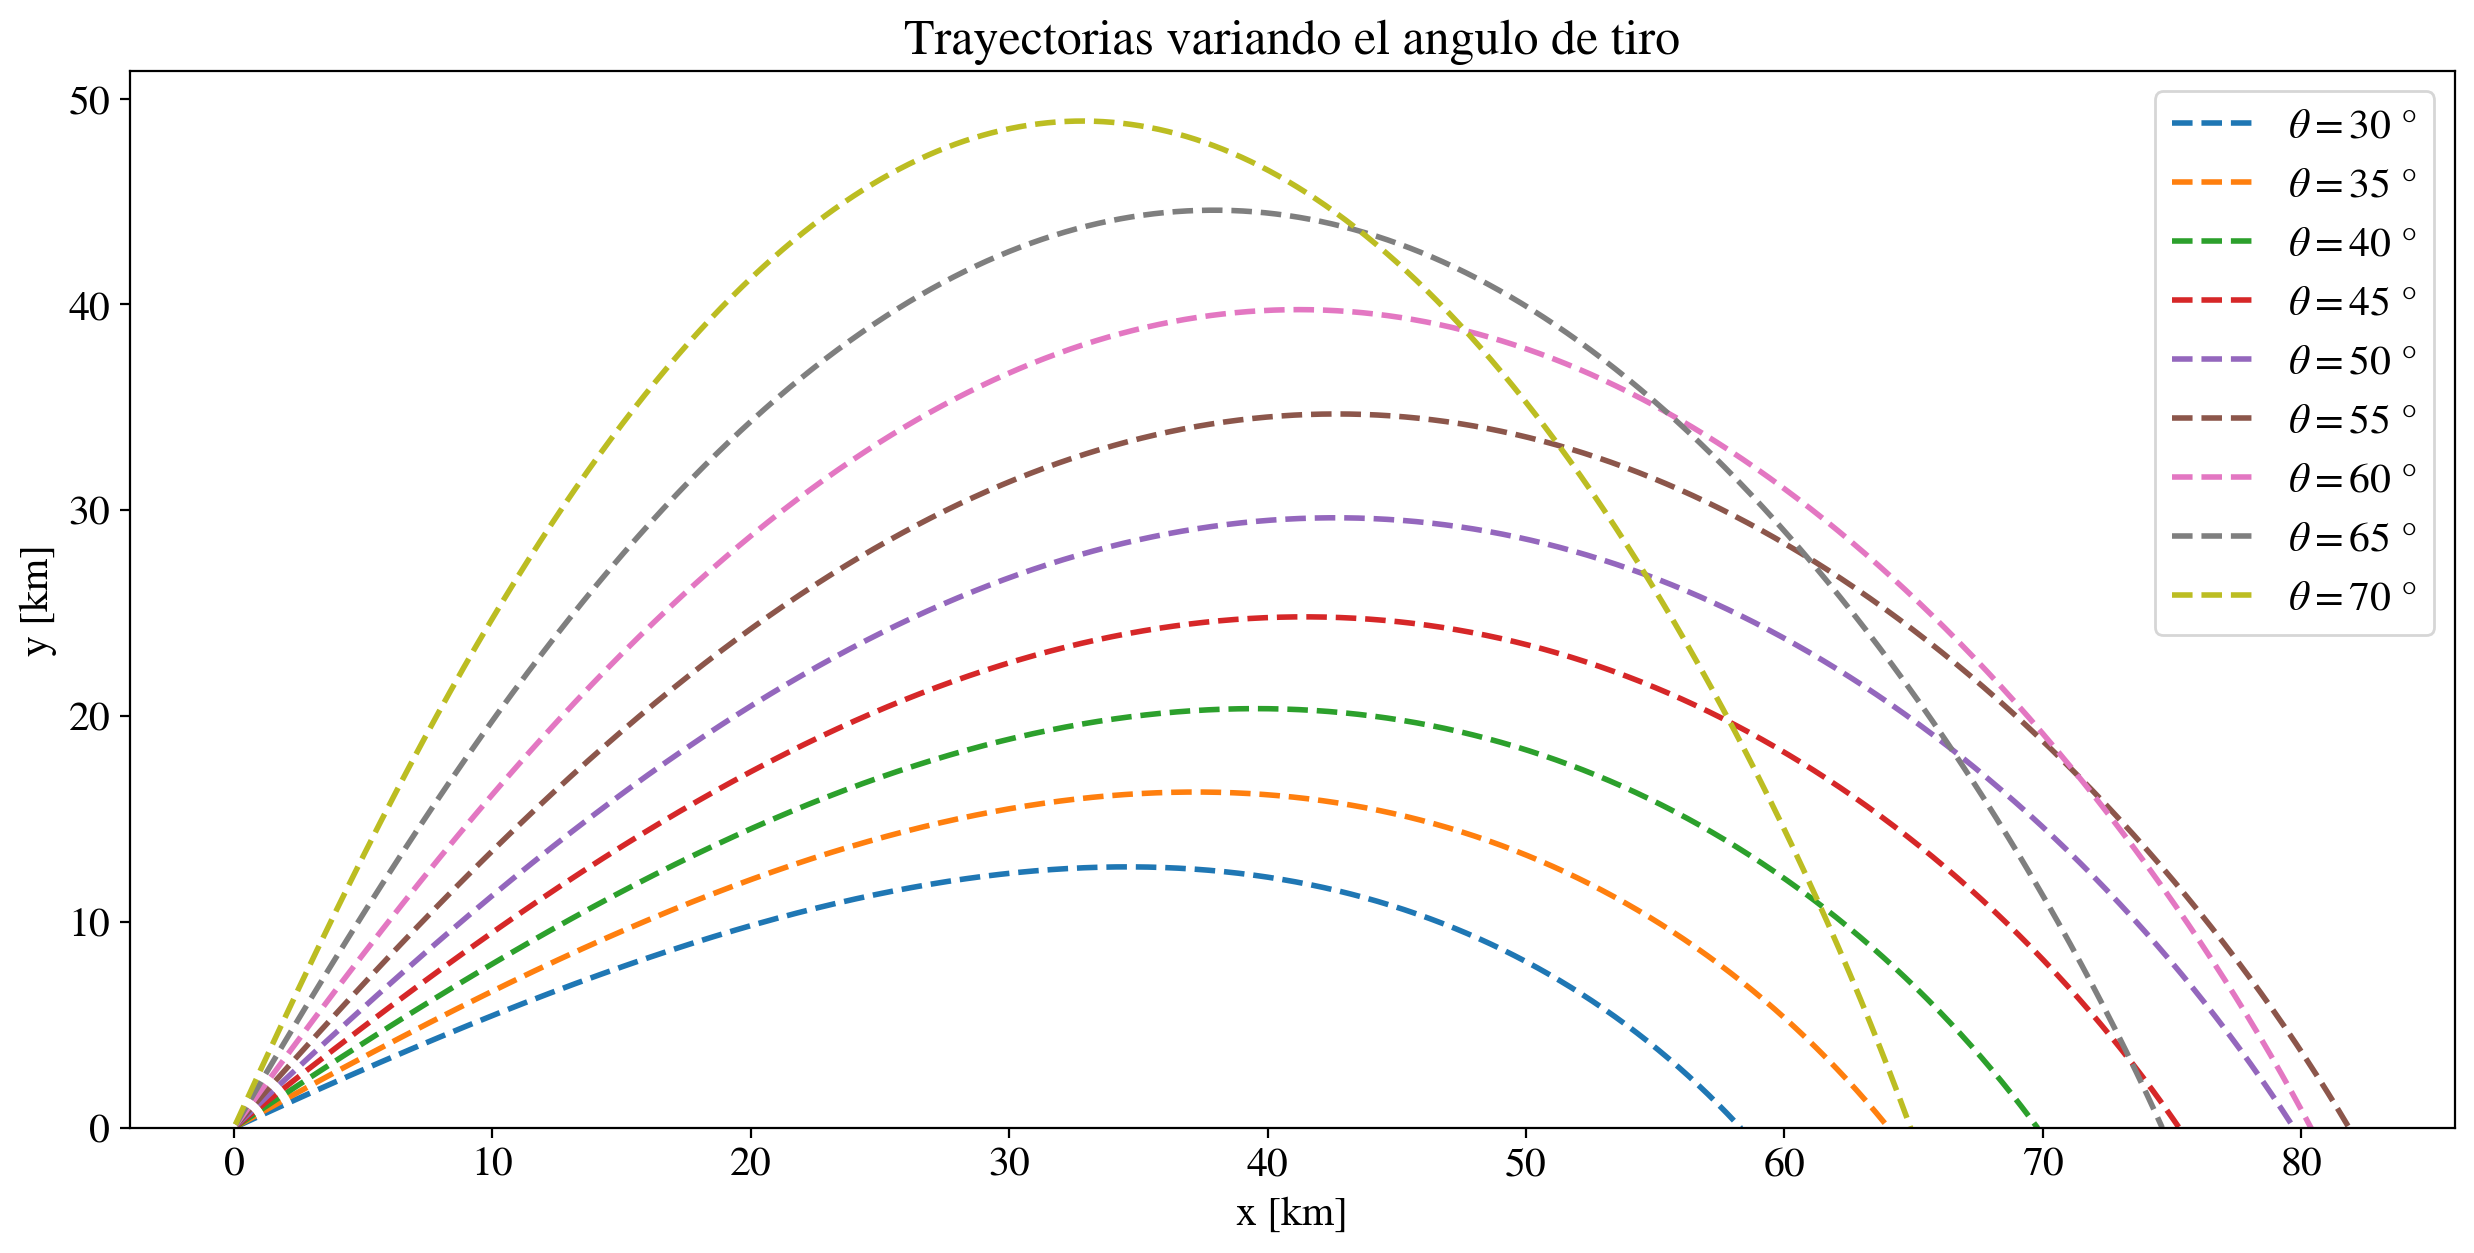

In [4]:
plt.plot(theta, x/1000)
plt.title(r"Alcance del proyectil en funcion del angulo de tiro, $\theta$")
plt.xlabel(r"$\theta $ [$\degree$]")
plt.ylabel(r"alcance [km]")

def trajectories(h):
    plt.figure()
    plt.title("Trayectorias variando el angulo de tiro")
    plt.xlabel(r"x [km]")
    plt.ylabel(r"y [km]")
    theta_list = np.arange(30.0,75,5)
    for angle in theta_list:
        x_list, y_list = projectile_motion(h, angle)
        plt.plot(x_list/1000, y_list/1000, '--', label=r'$\theta = $%.i $\degree$'%(angle))
    plt.legend(loc='best')
    plt.gca().set_ylim(bottom=0)
    plt.show()
trajectories(0.1)

En contraste con el caso en ausencia de fricción, el alcance máximo no se obtiene usando un ángulo de tiro de $\theta = 45^\circ$. Dando que la resistencia al avance es menor a mayores altitudes, el alcance aumenta cuando el proyectil pasa más tiempo volando a altas altitudes. Esta es la razón por la cual el alcance máximo se obtiene a $\theta = 55^\circ$.

### Validez numérica

Para determinar si la implementación numérica es válida, podemos usar el principio de conservación de la energía. Durante la trayectoria del proyectil, el medio realiza un trabajo sobre el proyectil, a través de la fuerza de resistencia al avance $\vec{F_D}$. El trabajo acumulado hecho sobre el móvil está dado por

$$
W = \int \vec{F_D} \cdot \vec{dr}.
$$

En nuestro modelo discreto, podemos calcular fácilmente esta integral mediante una suma de contribuciones infinitesimales, y aprovechando que $\vec{F_D}$ es siempre contrario al $\vec{dr}$ de forma que el trabajo acumulado a tiempo $t_M$, $M<N$, es igual a 

$$
W = \sum_{n=1}^{M} |\vec{F_{D_{n-1}}}| \cdot |\vec{r_n} - \vec{r_{n-1}}|,
$$

donde $\vec{F_{D_{n-1}}}$ es la fuerza de resistencia al avance en la posición $\vec{r_{n-1}}$. Sin embargo, nuevamente esto puede ser escrito de forma 

$$
W = h \sum_{n=1}^{M} |\vec{F_{D_{n-1}}}| \cdot |\vec{v_{n-1}}|,
$$

que es la más conveniente para nuestro propósito. Debemos notar que la elección del índice usado para la fuerza y la velocidad respectivamente, no es trivial, ya que ambos varían durante el intervalo $dr$. Aquí se usan tanto la velocidad como la fuerza en el punto $\vec{r_{n-1}}$. Esta es una elección práctica, ya que esta combinación ofrece la pérdida de energía más baja, y por ende, la más realista. Finalmente, podemos expresar la energía del proyectil (que no es otra que la suma de su energía potencial y cinética) y el trabajo hecho por el aire a tiempo $t_M$

$$
E(t_M) = h \sum_{n=1}^{M} |\vec{F_{D_{n-1}}}| \cdot |\vec{v_{n-1}}| + \frac{1}{2} m v_m^2 + mgy_m,
$$

donde $v_m$ es la velocidad absoluta del proyectil, e $y_m$ es la altura del proyectil sobre el suelo (punto de referencia para energía potencial cero).

Ahora solo resta verificar si esta expresión de la energía permanece constante mientras el proyectil está en el aire.

En este cuadernillo online, se implementó el método de Runge-Kutta method sin dificultades. Sin embargo, resulta interesante ver si era o no necesario usar un método de cuarto orden, en lugar uno más primitivo, como el método de Euler. El código siguiente usará ambos métodos, Runge-Kutta y Euler, comparando la pérdida de energía durante el movimiento para ambos casos.

Con angulo de tiro 45.0 grados y paso de tiempo h = 0.10 segundos:
Perdida de energia con RK4: -7.395E+03 = -0.01 por ciento del total
Perdida de energia con Euler: 2.735E+05 = 0.41 por ciento del total


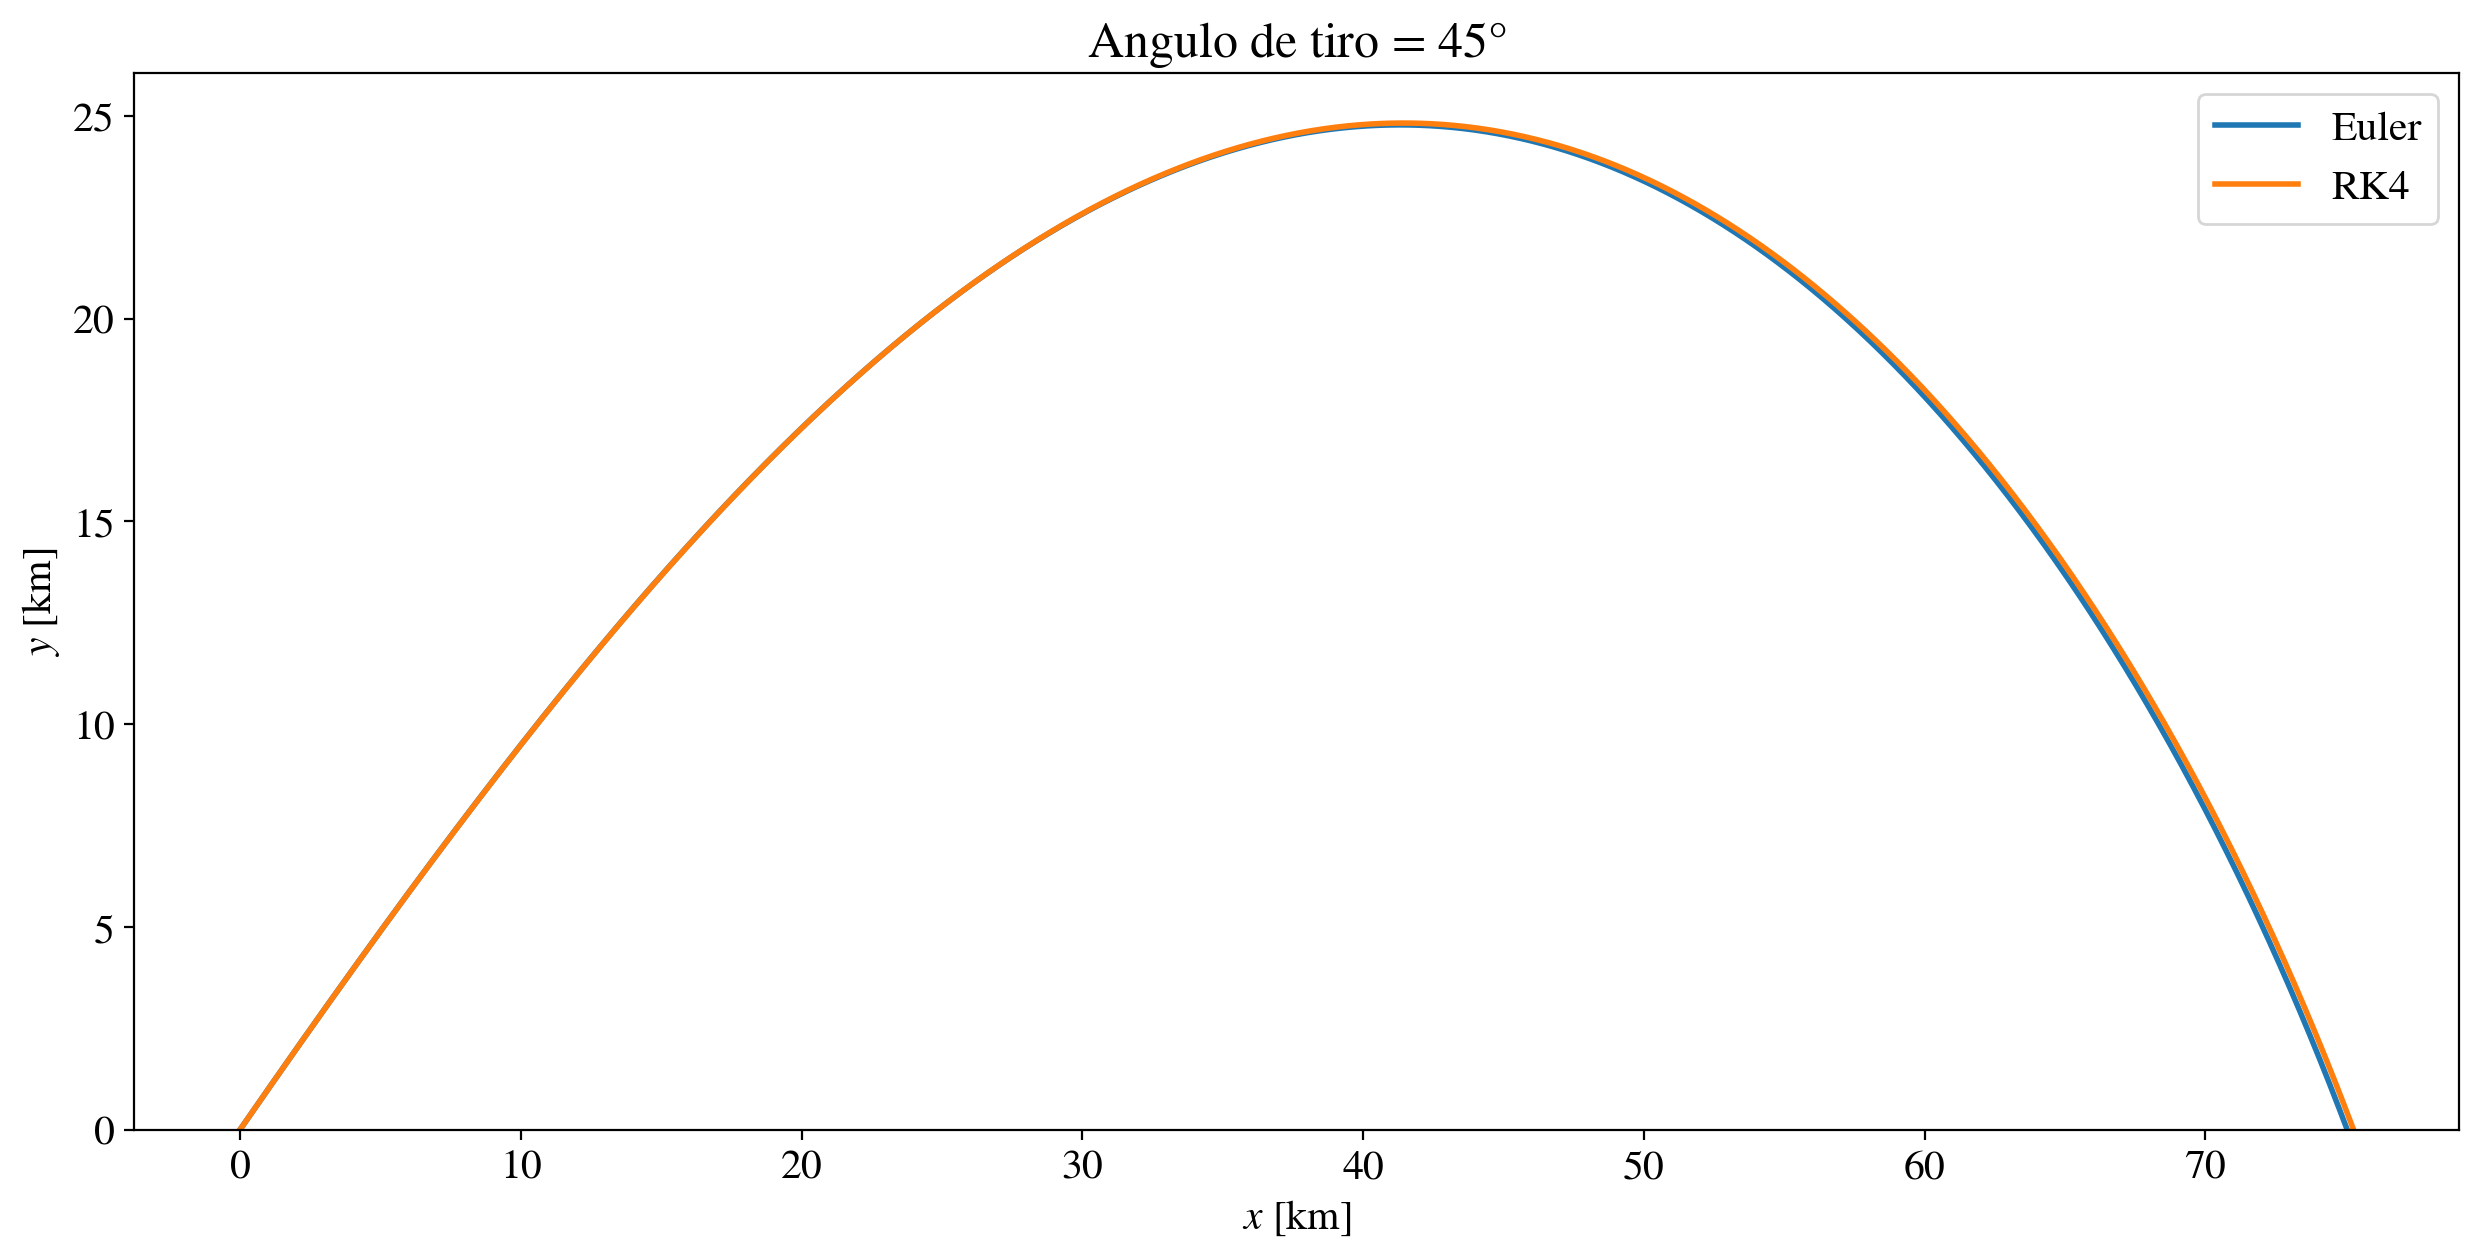

In [6]:
def euler_step(f ,w ,h):
    """Implementacion simple del metodo de Euler vectorial
    """
    return w + h * f(w)

def energy_conservation(h, theta, func):
    """ Esta funcion realiza los mismos pasos que "projectile_motion()" y "f()"
    pero extrae el valor de F_D en casa paso. Esto permite el calculo del 
    trabajo y energia a cada paso de tiempo.
    Parametros:
        h           paso de integracion
        theta       angulo de tiro inicial
        func        una funcion que define el tipo de intregracion (euler o RK4)
    Devuelve:
        x_list      array de coordenadas x de la trayectoria
        y_list      array de coordenadas y de la trayectoria
        time_steps  array del tiempo transcurrido a cada paso
        energy      array de la energia a cada paso
        work        trabajo total realizado for F_D
    """
    w = shoot(theta, v_0)
    
    x_list = np.zeros(1)
    y_list = np.zeros(1)
    work = 0
    
    # Energia total inicial
    v = np.sqrt(w[2] ** 2 + w[3] ** 2)
    energy = np.array([0.5 * m * v ** 2])
    
    
    while w[1] >= 0:
        w = func(f, w, h)
        
        # Actualizar las listas
        x_list = np.append(x_list, w[0])
        y_list = np.append(y_list, w[1])
        
        # Parametros temporales para verificar alta altitud
        k = (1 - a * y_list[-2] / T_0)
        s = np.sqrt((w[2] - V[0]) ** 2 + (w[3] - V[1]) ** 2)
        if k > 0:
            F_D = B * k ** (alpha) * s ** 2
        else:
            F_D = 0
        
        # Sumar el trabajo realizado por F_D en este intervalo de t
        work +=  v * F_D * h
        # Actualizar la velocidad para calcular la perdida de energia
        v = np.sqrt(w[2] ** 2 + w[3] ** 2)
        # Usar np.sum en la lista de trabajos para calcular el acumulado
        energy = np.append(energy, 0.5 * m * v ** 2 + m * g * w[1] + work)
    
    n = len(x_list)
    time_steps = np.linspace(0, n * h, n)
    
    return x_list, y_list, time_steps, energy, work
 

# Valores iniciales
theta = 45
h = 0.1
# Obteniendo los resultados
x_list_euler, y_list_euler, time_steps_euler, energy_euler, work = energy_conservation(h, theta, euler_step)
x_list_RK4, y_list_RK4, time_steps_RK4, energy_RK4, work = energy_conservation(h, theta, RK4_step)

print("Con angulo de tiro %.1f grados y paso de tiempo h = %.2f segundos:" %(theta, h))
print("Perdida de energia con RK4: %.3E = %.2f por ciento del total" %(energy_RK4[0] - energy_RK4[-1],
                                          (energy_RK4[0] - energy_RK4[-1]) / energy_RK4[0] * 100))
print("Perdida de energia con Euler: %.3E = %.2f por ciento del total" %(energy_euler[0] - energy_euler[-1],
                                        (energy_euler[0] - energy_euler[-1]) / energy_euler[0] * 100))

# Plotting the separate trajectories 
plt.plot(x_list_euler/1000, y_list_euler/1000, label ="Euler")
plt.plot(x_list_RK4/1000, y_list_RK4/1000, label ="RK4")
plt.title("Angulo de tiro = " + str(theta) + "$\degree$")
plt.xlabel(r"$x$ [km]")
plt.ylabel(r"$y$ [km]")
plt.gca().set_ylim(bottom=0)
plt.legend()
plt.show()

A partir de la figura de arriba, es claro que en este caso, el método de Euler funciona sorprendentemente bien. Produce casi la misma trayectoria que el método de Runge-Kutta de cuarto orden. La explicación más razonable para tan pequeñas diferencias es que el sistema de EDOs acopladas que estamos resolviendo es bastante lineal, o en otras palabras, las derivadas varían bastante poco. Por esta razón, el método de Euler brinda valores de solución aceptables.

Puede parecer que perder $10^3$ joules es mucho, pero debemos tener presente las enormes dimensiones del cañon de Paris, y que esta pérdida es solo una pequeña fracción de la energía original del proyectil. 

## La física detrás de los números
Aún cuando la cantidad de energía perdida es relativamente poca, resulta igualmente interesante estudiar la naturaleza de dicha pérdida. En nuestro caso, resulta que la explicación tiene raices tanto en la física como en lo numérico del problema. 

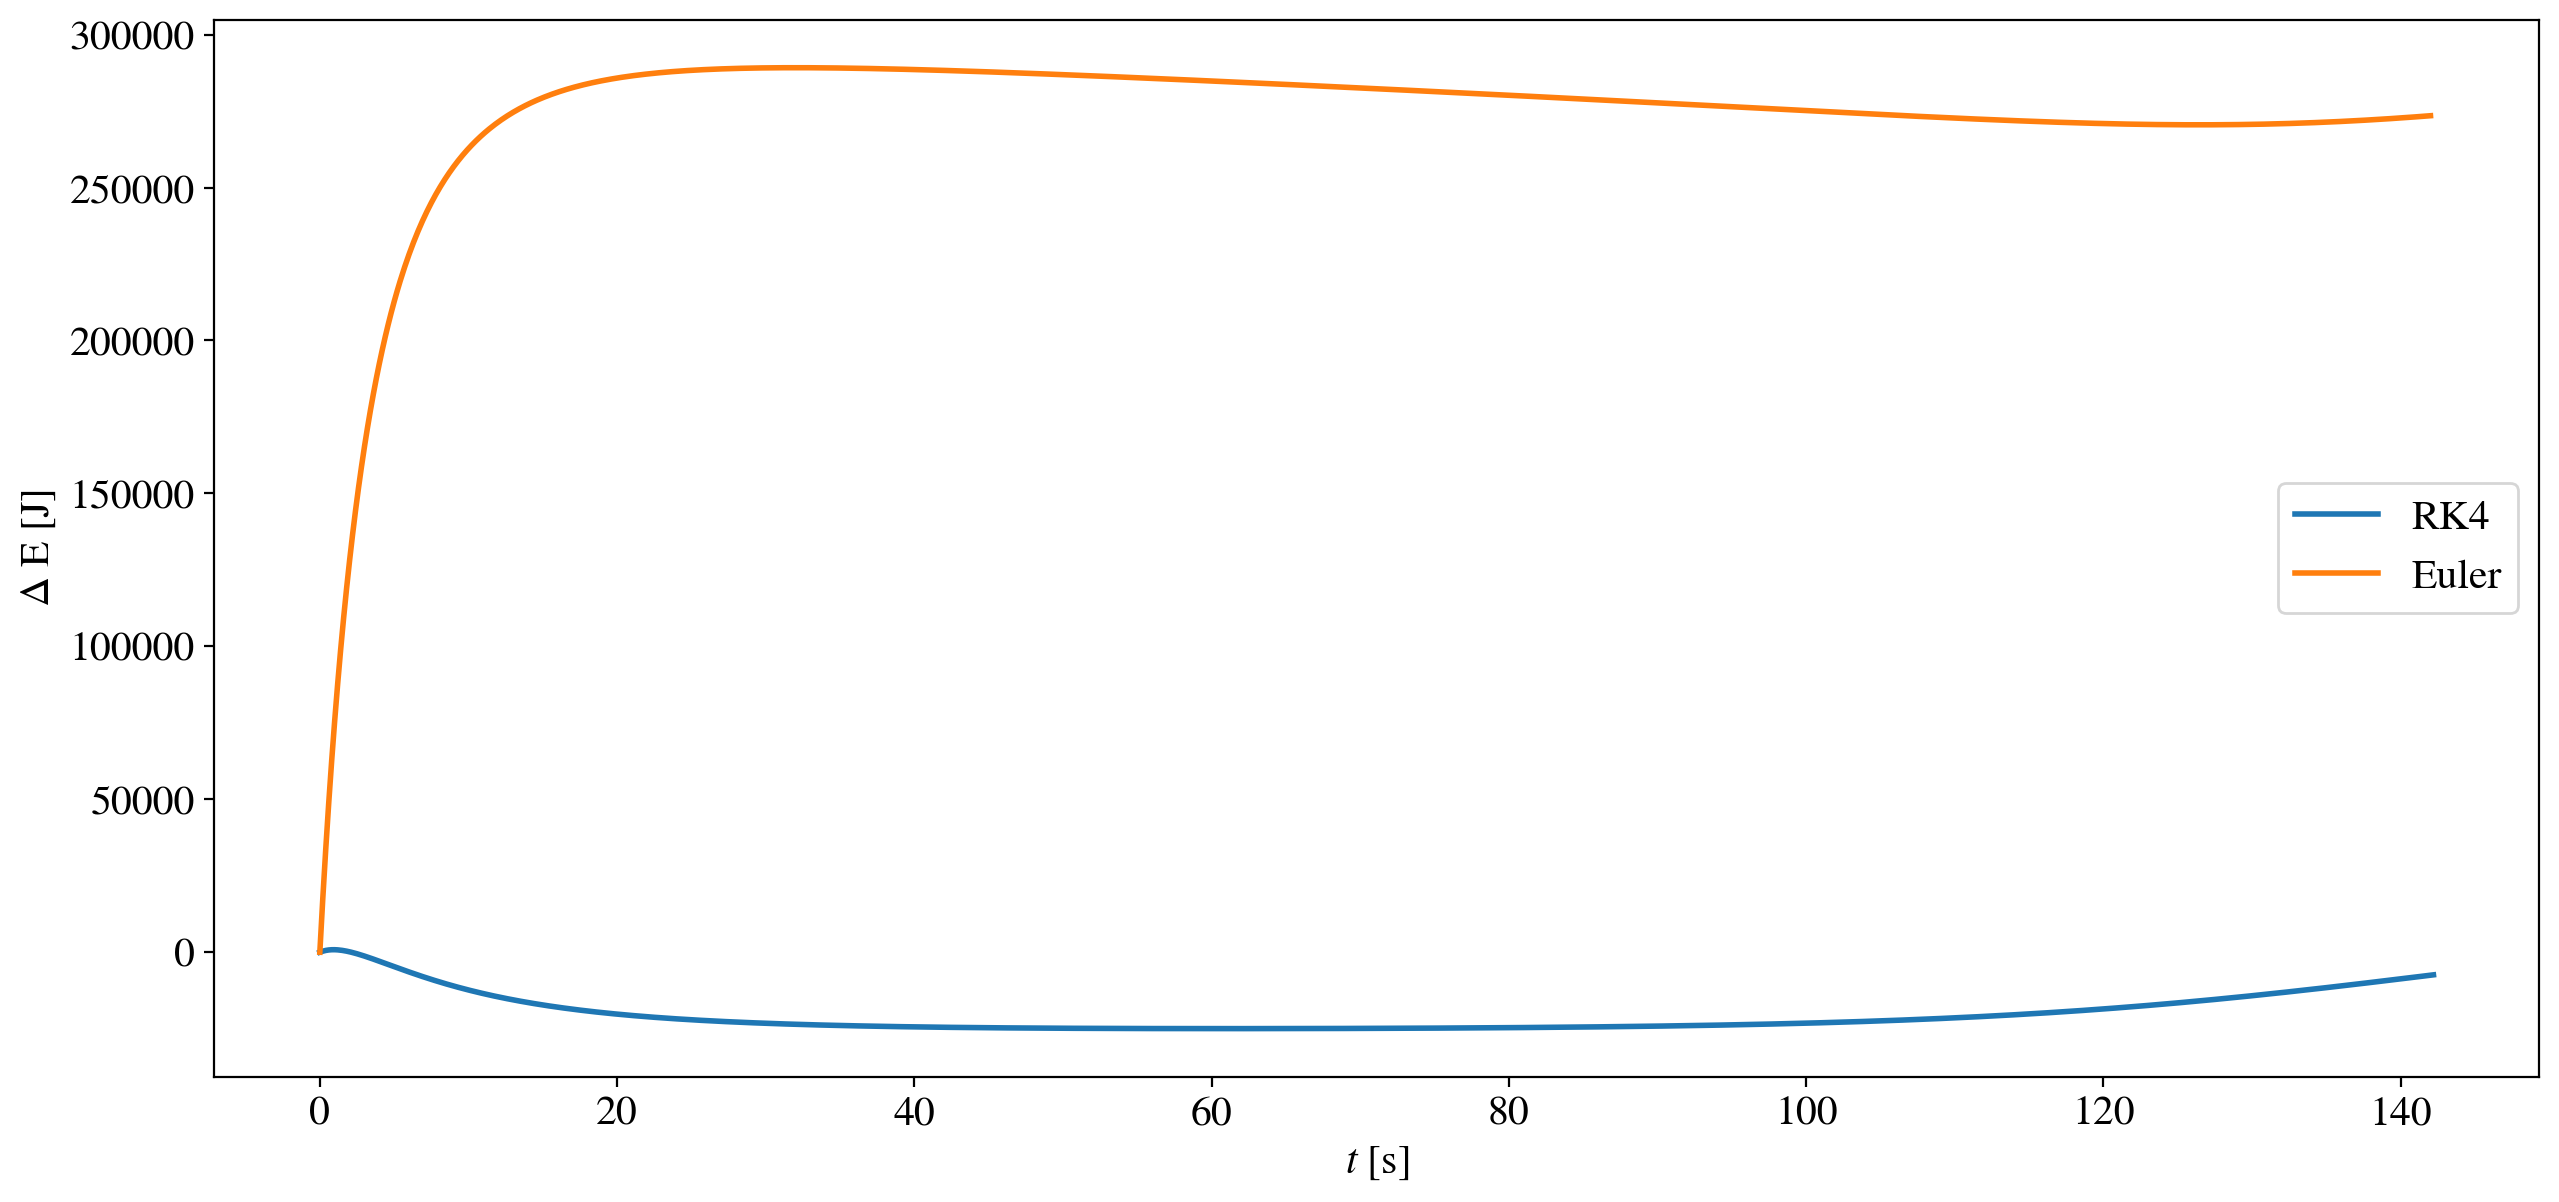

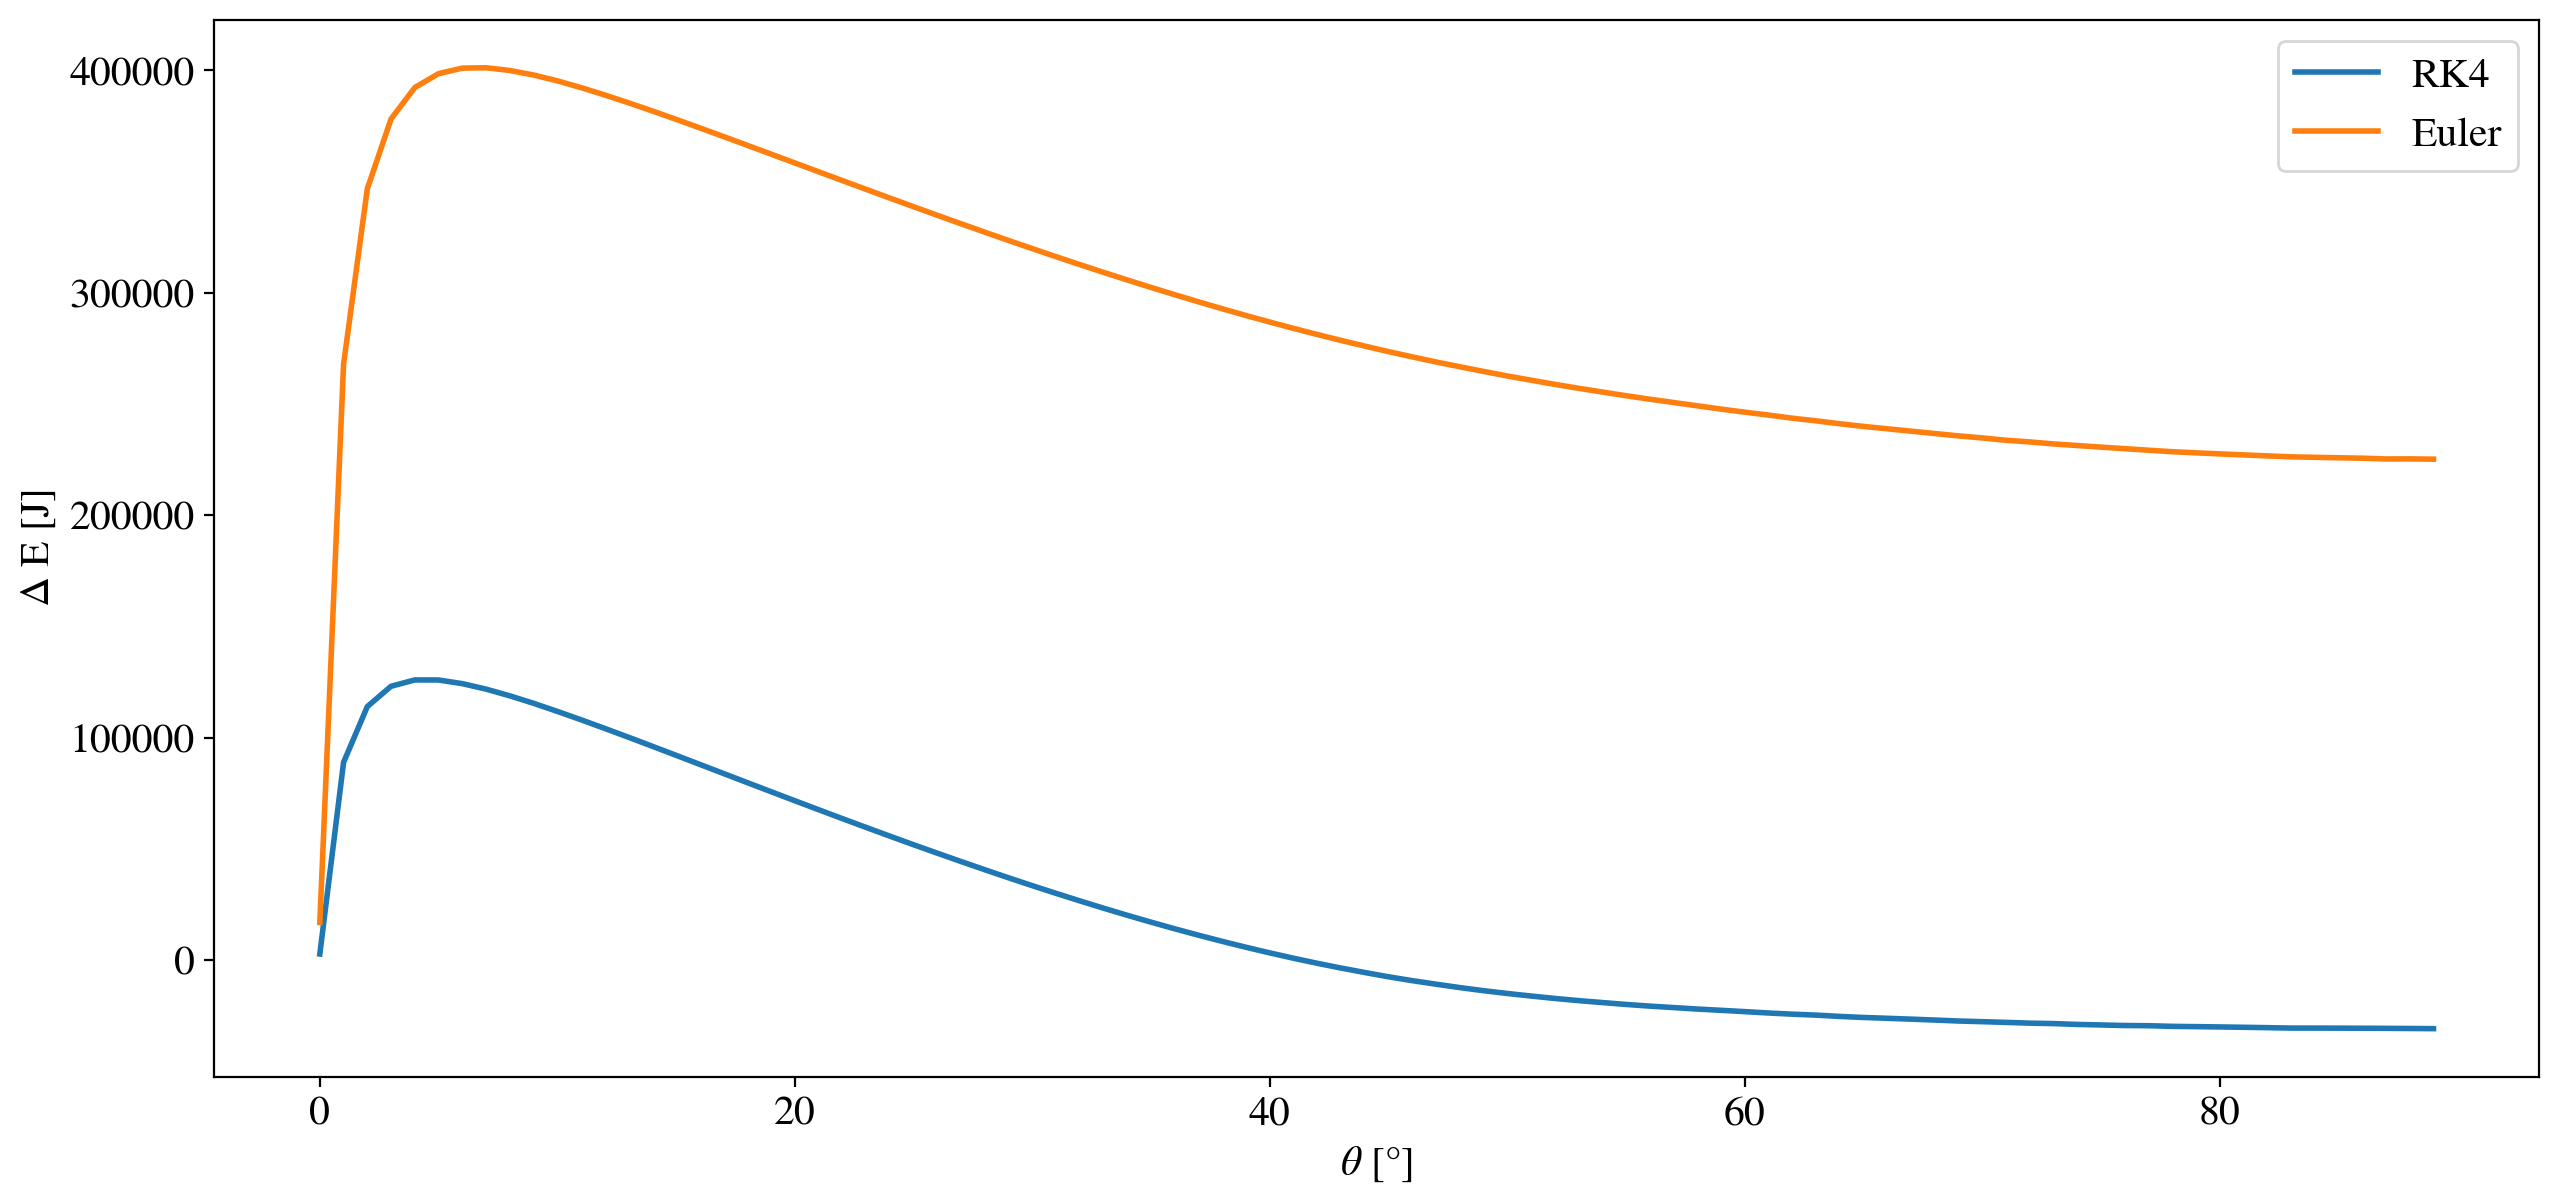

In [9]:
# Cuando desaparece la energia durante el vuelo?
starting_energy_RK4 = np.repeat(energy_RK4[0], len(energy_RK4))
starting_energy_euler = np.repeat(energy_euler[0], len(energy_euler))

plt.plot(time_steps_RK4, starting_energy_RK4 - energy_RK4, label = "RK4")
plt.plot(time_steps_euler, starting_energy_euler - energy_euler, label = "Euler")
plt.legend()
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\Delta $ E [J]")

plt.show()


# Explorando la validez numerica como funcion del angulo de tiro
energy_loss_euler = np.zeros(0)
energy_loss_RK4 = np.zeros(0)
angles = np.zeros(0)
for i in range(90):
    energy_euler = energy_conservation(0.1, i, euler_step)[3] # solo devuelve el cuarto valor de retorno
    energy_loss_euler = np.append(energy_loss_euler, energy_euler[0] - energy_euler[-1])
    energy_RK4 = energy_conservation(0.1, i, RK4_step)[3]
    energy_loss_RK4 = np.append(energy_loss_RK4, energy_RK4[0] - energy_RK4[-1])
    angles = np.append(angles, i)

plt.plot(angles, energy_loss_RK4, label ="RK4")
plt.plot(angles, energy_loss_euler, label ="Euler")
plt.legend()
plt.xlabel(r"$\theta $ [$\degree$]")
plt.ylabel(r"$\Delta $ E [J]")
plt.show()

La primera figura ilustra como difiere la energía durante la trayectoria respecto a la energía original del proyectil. Tanto el método de Euler como el de Runge-Kutta demuestran el mismo comportamiento numérico, la principal contribución al error en energía ocurre a bajas altitudes, al inicio y final de la trayectoria. Como el proyectil alcanza rápidamente altitudes importantes, donde la densidad del aire es baja, la resistencia al avance decrece. Cuando la fuerza de resistencia es despreciable, el movimiento del proyectil puede ser descripto analíticamente mediante una expresión de segundo orden, lo cual es tarea sencilla para el método de R-K de cuarto orden. La pérdida de energía mayor que muestra el método de Euler es esperable, pues la resistencia es proporcional a $v^3$ y debido a que la velocidad es mucho mayor durante el inicio de la trayectoria, las derivadas de $u$ y $v$ cambian más rápidamente, una complicación para el método de Euler. 

La misma explicación vale para el segundo gráfico. Cuanto menor el tiempo que el proyectil se encuentra a menor altitud, menor la pérdida de energía. Si el ángulo de tiro es bajo, el proyectil no alcanzará las altitudes donde la densidad del aire y la pérdida de energía son menores. 

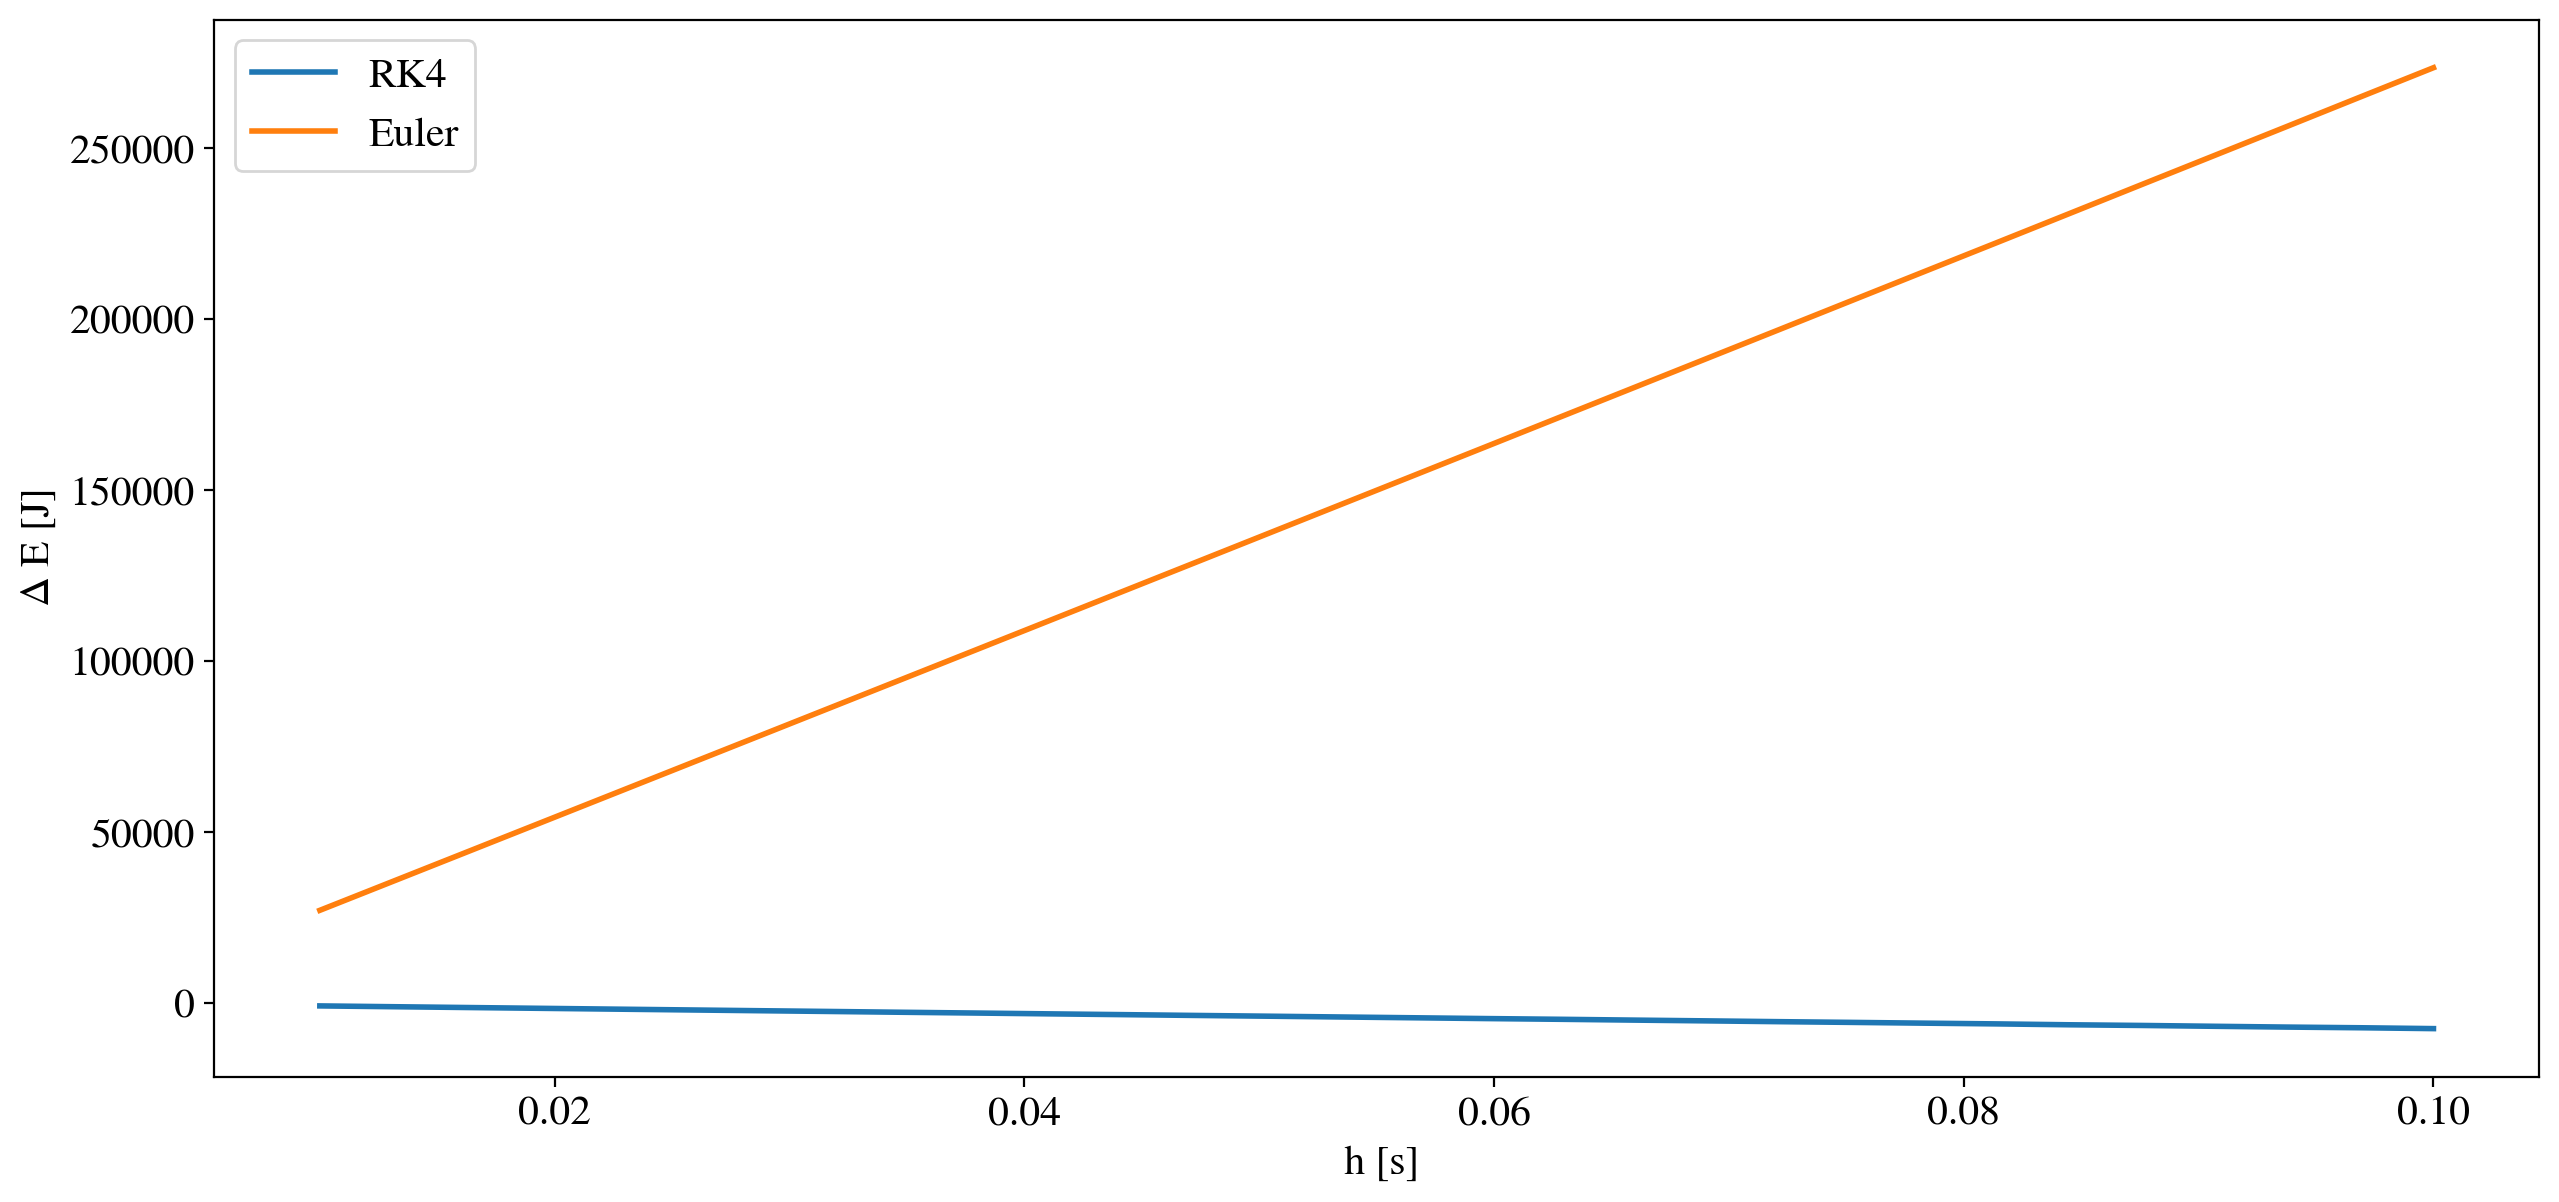

In [10]:
# Explorando la validez numerica como funcion de la longitud del paso h
theta = 45

h_list = np.linspace(0.01, 0.1, 30)

energy_loss_euler = np.zeros(0)
energy_loss_RK4 = np.zeros(0)

for h in h_list:
    energy_euler = energy_conservation(h, theta, euler_step)[3]
    energy_loss_euler = np.append(energy_loss_euler, energy_euler[0] - energy_euler[-1])
    energy_RK4 = energy_conservation(h, theta, RK4_step)[3]
    energy_loss_RK4 = np.append(energy_loss_RK4, energy_RK4[0] - energy_RK4[-1])
plt.plot(h_list, energy_loss_RK4, label ="RK4")
plt.plot(h_list, energy_loss_euler, label ="Euler")
plt.legend()
plt.xlabel(r" h [s]")
plt.ylabel(r"$\Delta $ E [J]")
plt.show()

La última verificación numérica corresponde a la desviación de energía dependiendo de la longitud del paso $h$. Como es de esperar, la desviación se reduce conforme $h$ se achica, y el error parece variar linealmente con ambos métodos.

¿Cuál solver es superior para este proyecto? Runge-Kutta produce los resultados más realistas y a expensas de solo 4 líneas de código extras. Vale decir que ambos métodos producen trayectorias similares, por lo que el método de Euler podría ser suficiente si nuestro único objetivo fuera la determinación de trayectorias.

### El efecto del viento

En esta sección, veremos como el viento afecta a la trayectoria de un proyectil. Como las dimensiones del cañon de Paris son muy grandes como para ser afectado por magnitudes de viento realistas, usaremos las dimensiones de un cañon ficticio que llamaremos el cañon-Cito. Debido a su menor potencia, consideraremos que la densidad del aire es aproximadamente constante, esperamos que el máximo alcance se obtenga para un ángulo menor que en el caso anterior. Veamos como resultan afectados el alcance y la trayectoria del proyectil sujeto a viento.

El angulo optimo es:  41  grados, sin viento. 
Las trayectorias sin viento:


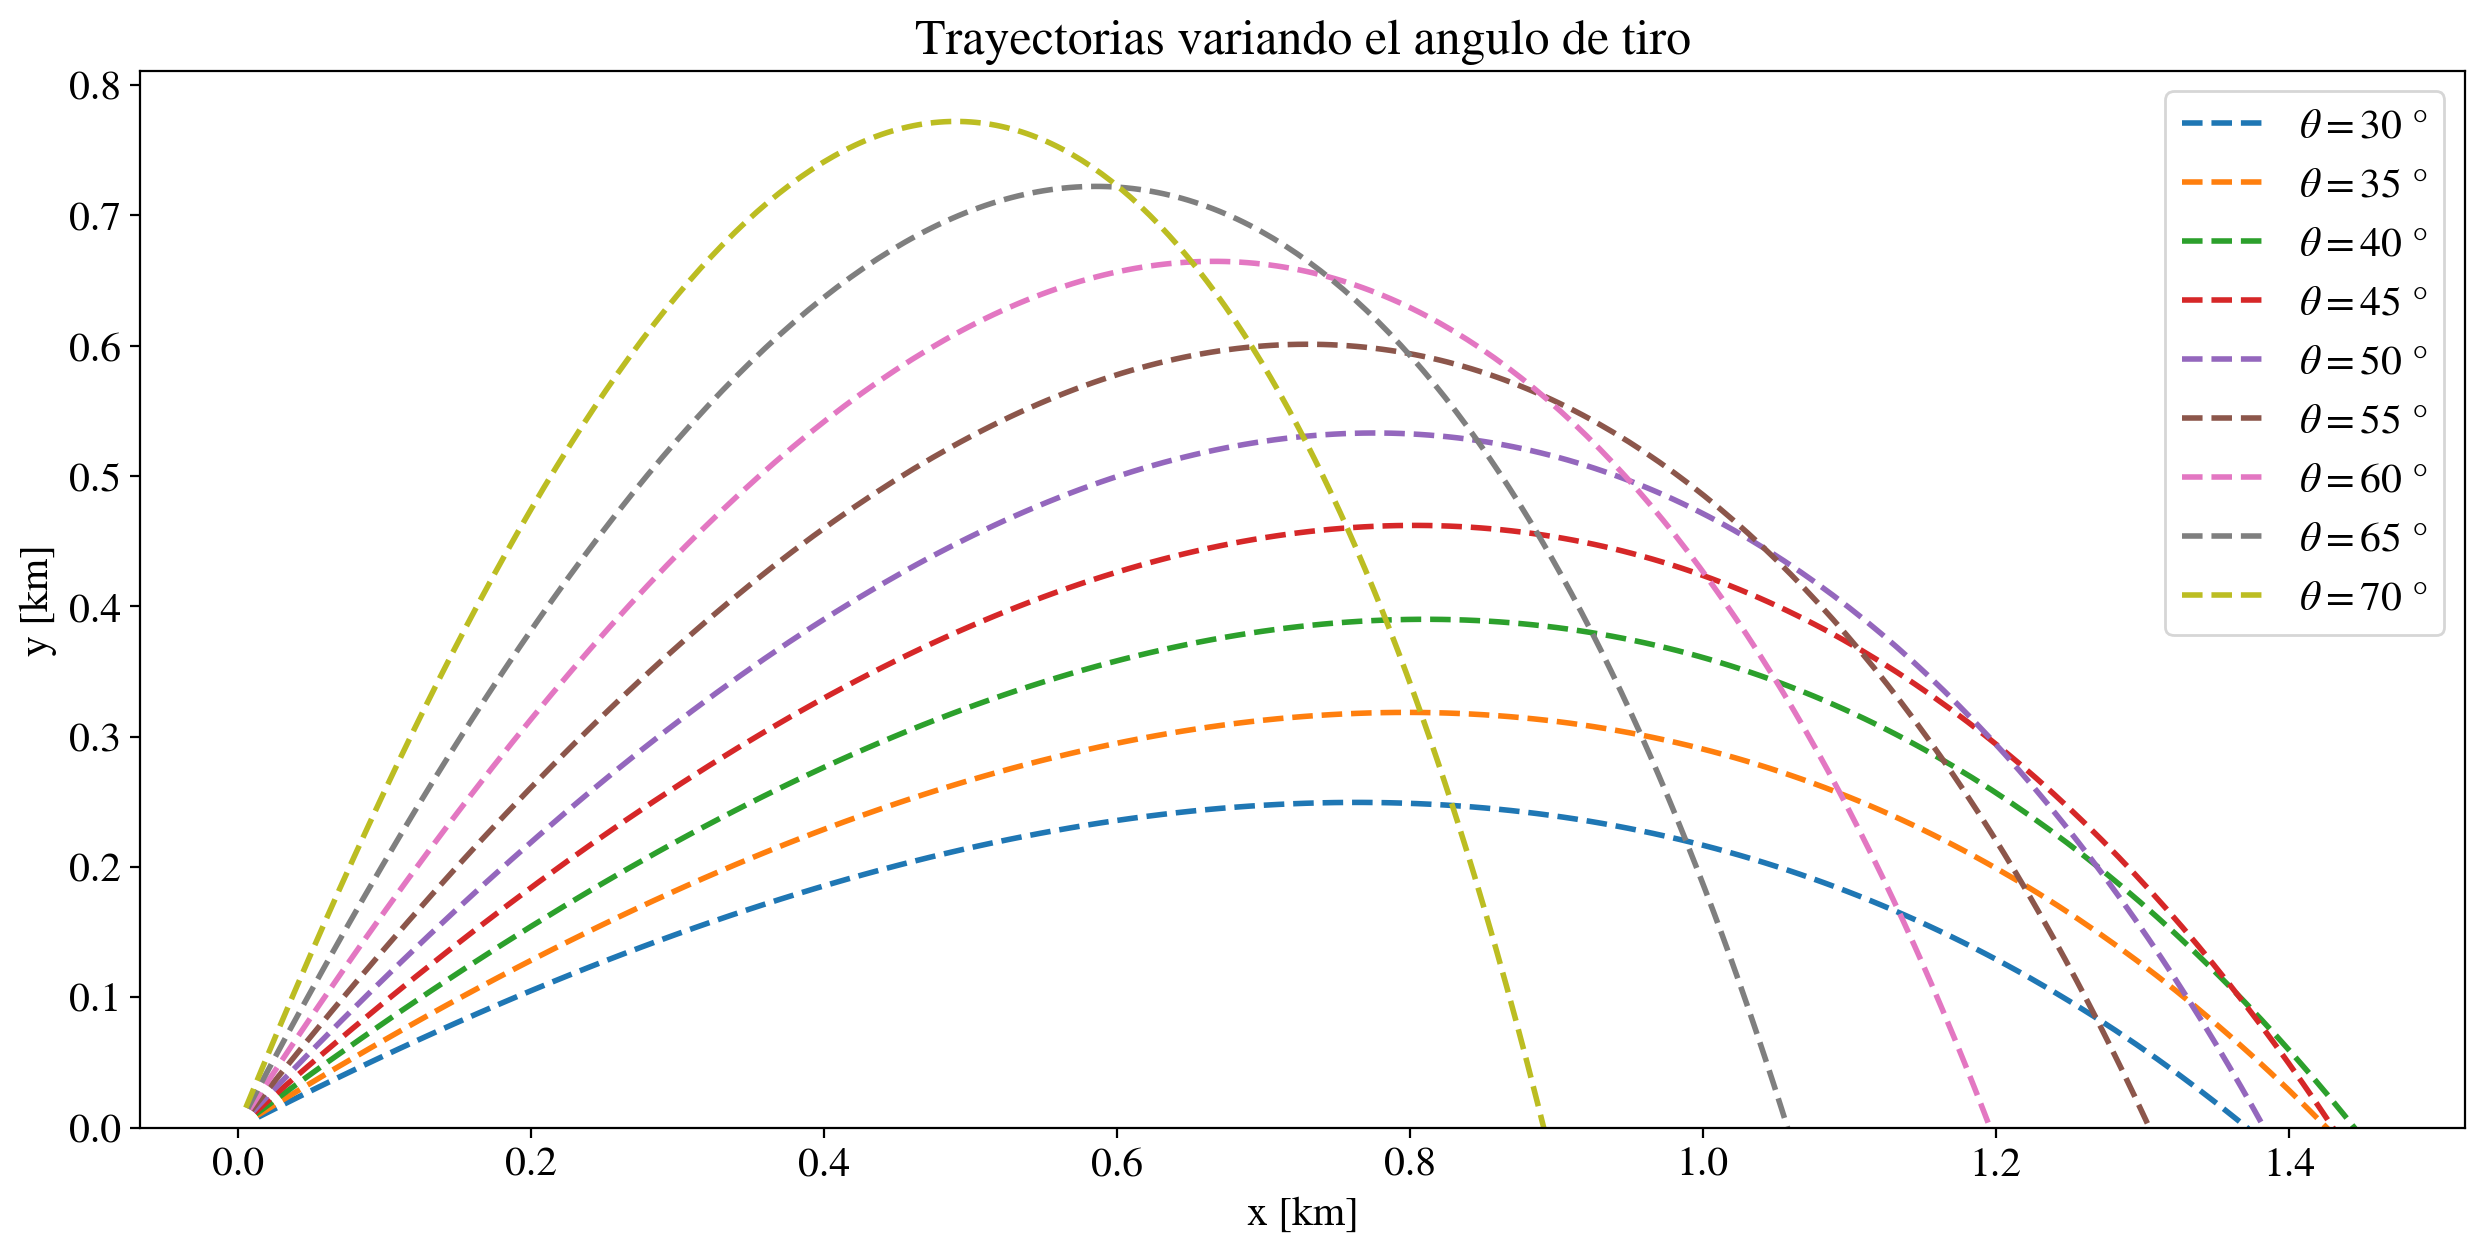

El angulo optimo es:  43  grados, con viento de cola fuerte. 
Las trayectorias con viento de cola:


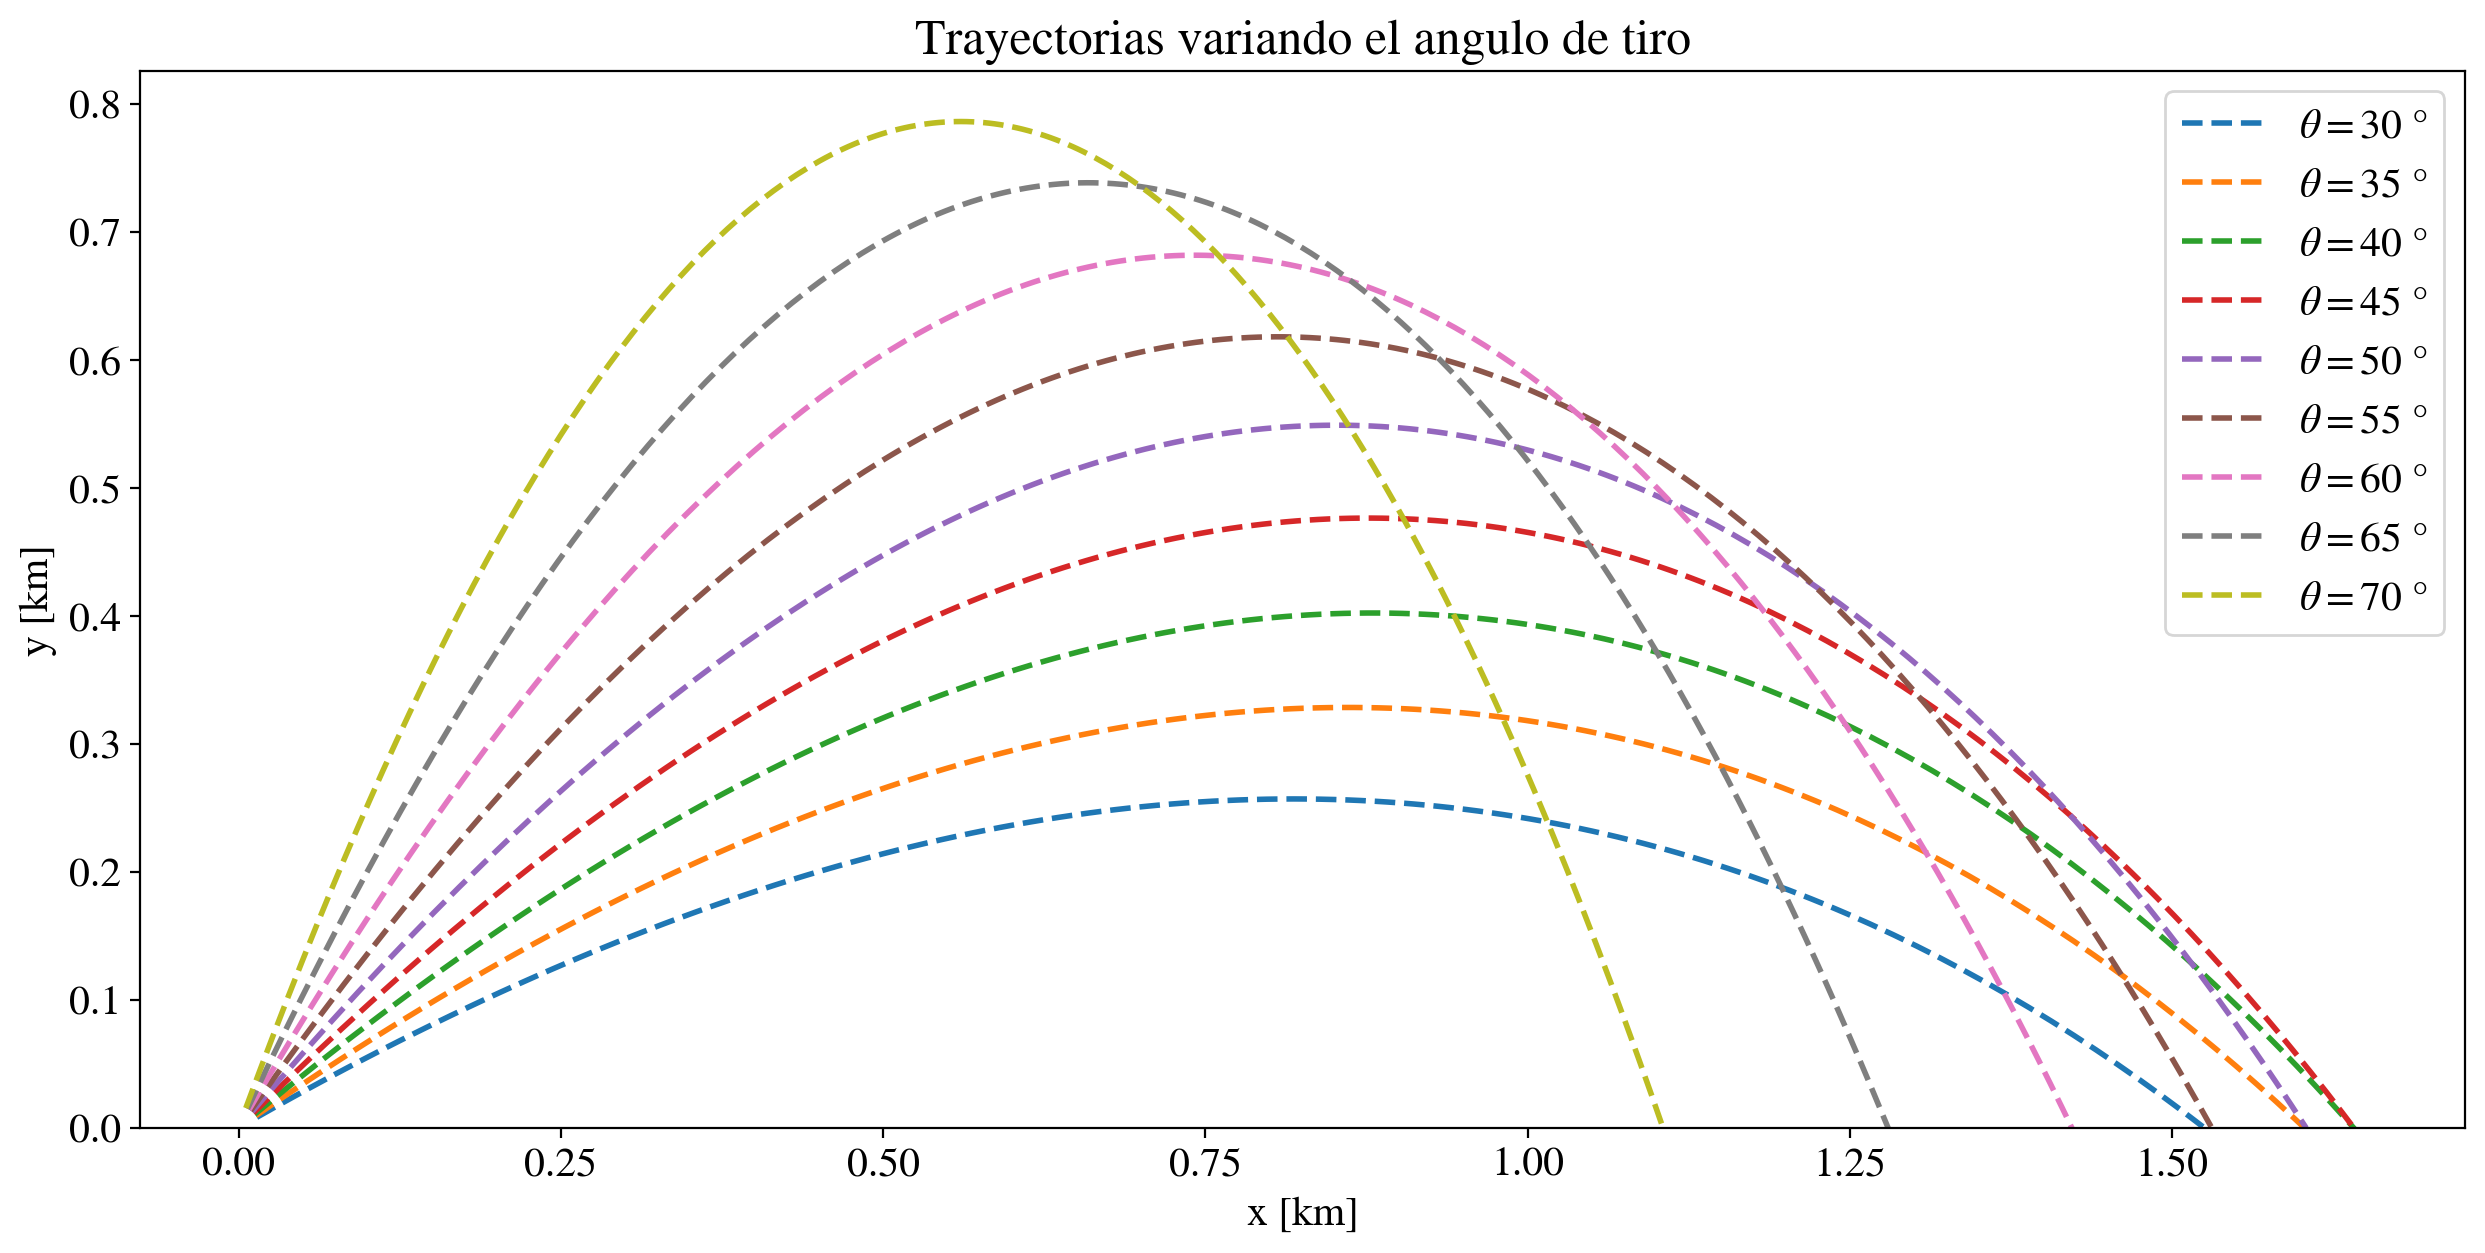

El angulo optimo es:  37  grados con viento de frente fuerte 
Las trayectorias con viento de frente:


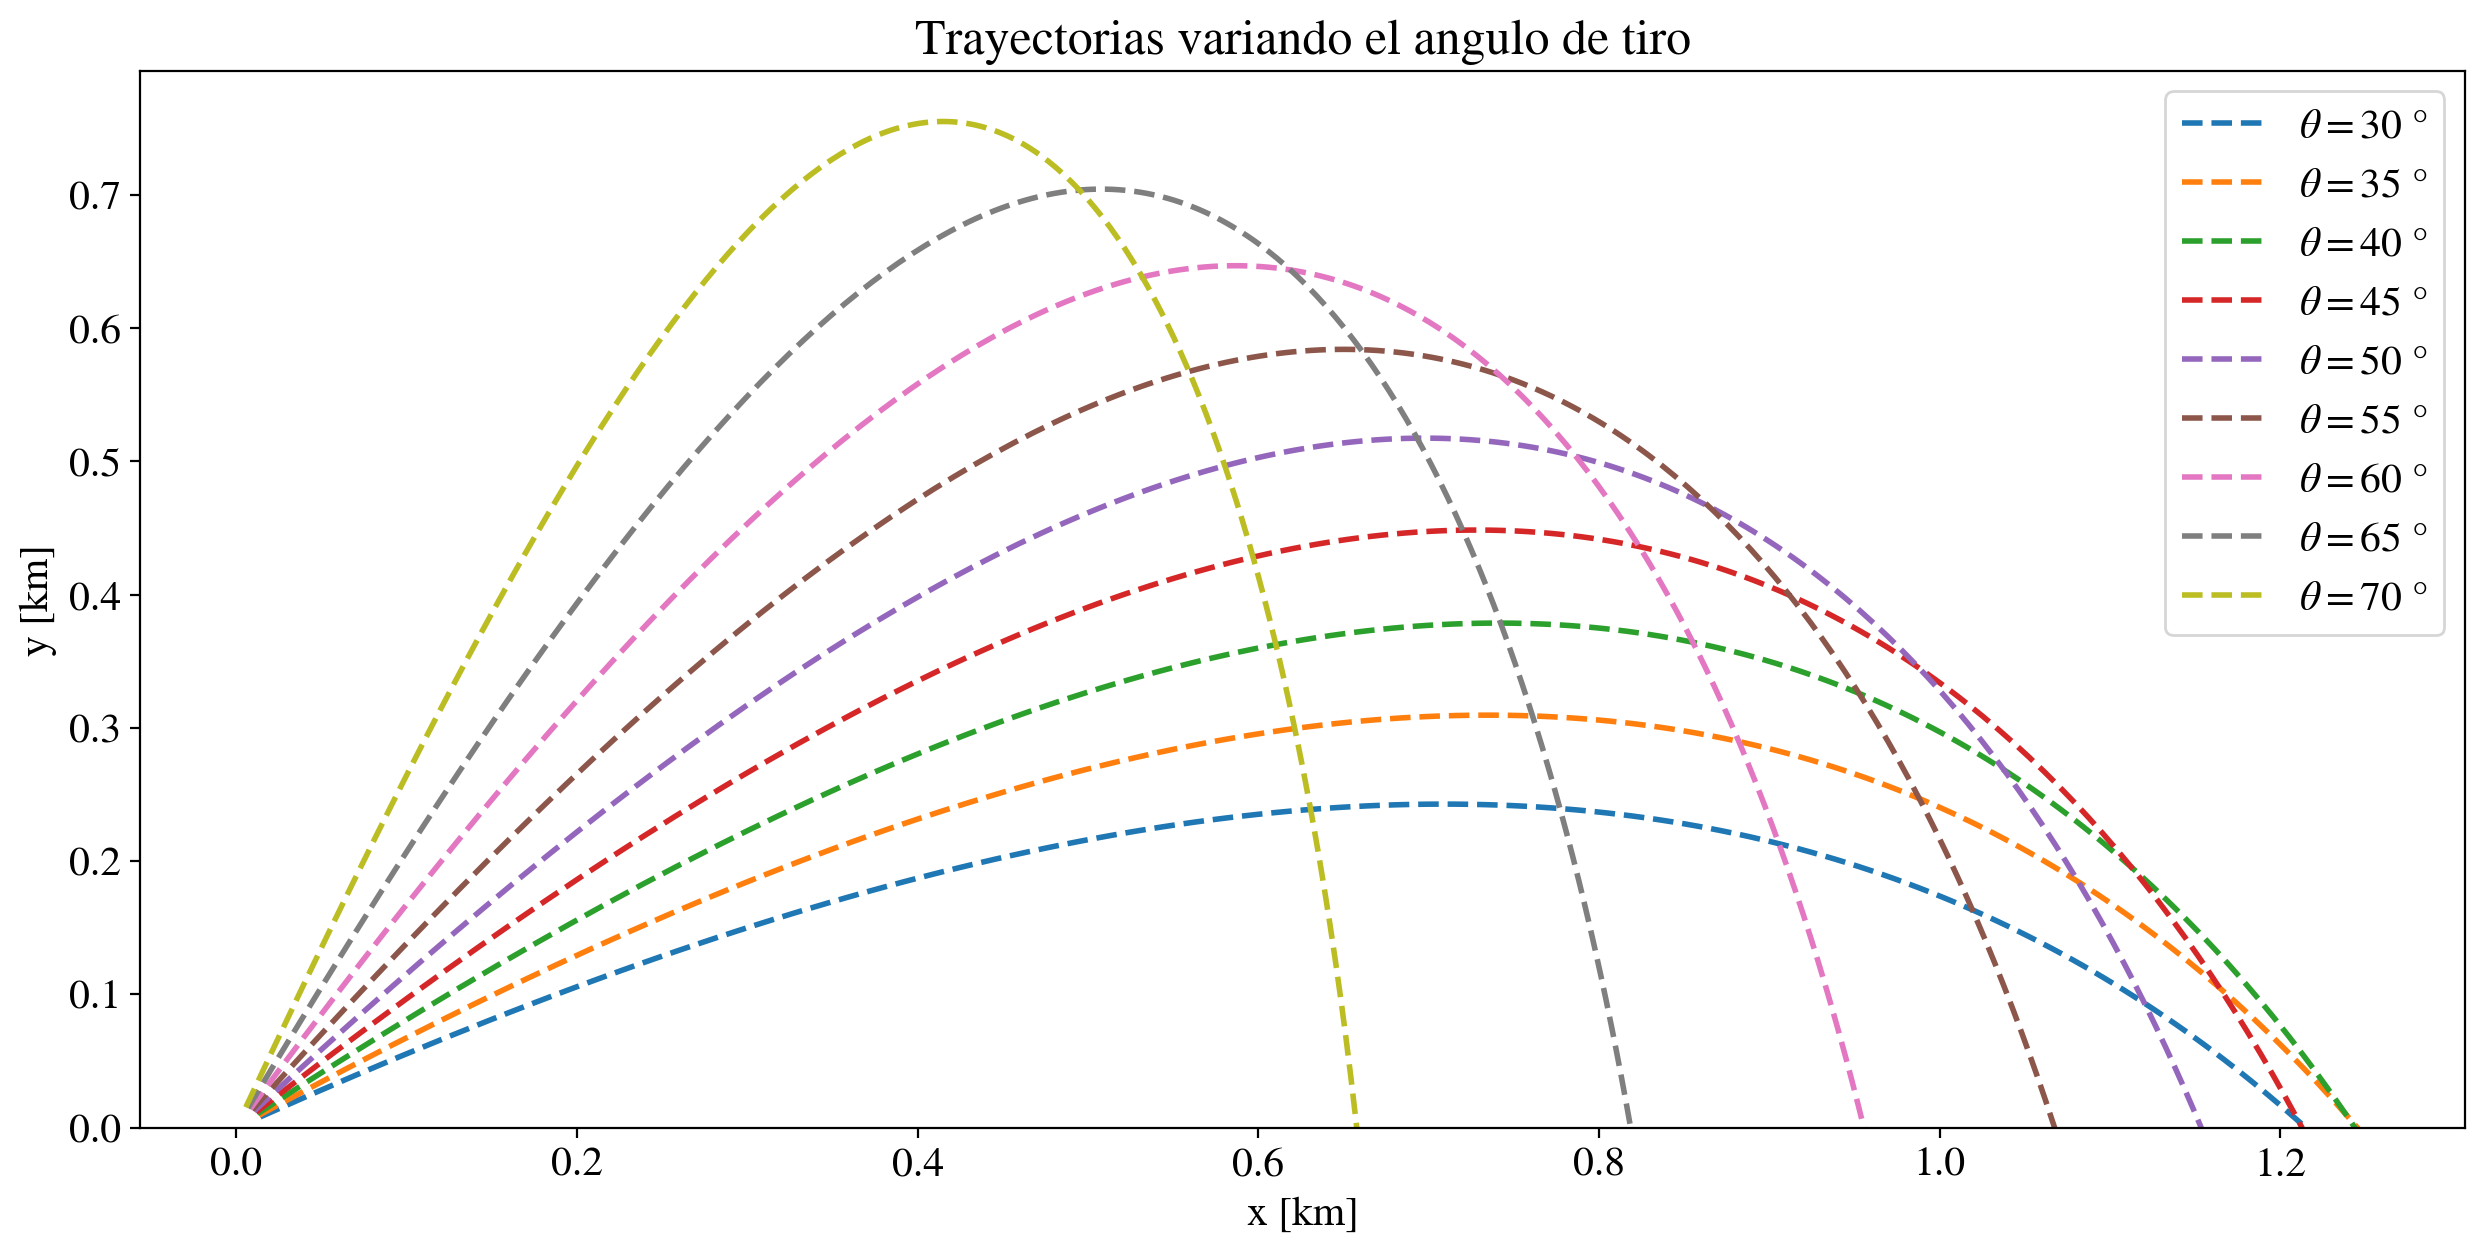

In [12]:
# Reinicializamos variables
m = 10             # Masa del proyectil
B = 5 * 10 ** (-3) # Constante 
v_0 = 164          # Velocidad inicial


# Intensidad del viento
V = np.zeros(2)

print("El angulo optimo es: ", find_optimal_angle(0.1)[2], 
      " grados, sin viento. \nLas trayectorias sin viento:")            
trajectories(0.1)

V[0] = 20 # Viento de cola fuerte en dir horizontal
print("El angulo optimo es: ", find_optimal_angle(0.1)[2], 
      " grados, con viento de cola fuerte.", 
      "\nLas trayectorias con viento de cola:")            
trajectories(0.1)

V[0] = -20 # Viento de frente fuerte en dir horizontal
print("El angulo optimo es: ", find_optimal_angle(0.1)[2], 
      " grados con viento de frente fuerte", 
      "\nLas trayectorias con viento de frente:")                     
trajectories(0.1)

Como es de esperar, el viento afecta las trayectorias. Cuando el proyectil experimenta viento de cola, la fuerza de resistencia al avance decrece, por lo que el movimiento se asemeja al de la solución analítica en el caso sin fricción. Por esto, el ángulo óptimo se acerca a $45^\circ$. En el caso opuesto, con viento de frente, la resistencia al avance se ve incrementada, lo que hace que el ángulo de tiro óptimo baje, ya que se aprovecha mejor la energía del disparo cuanto menor tiempo transcurra el proyectil en el aire. 

### Tarea para el hogar

Seguramente lleguen a este punto y deseen emplear estas ecuaciones para hacer justicia por mano propia. En tal caso, necesitarán considerar que el viento puede no tener la misma dirección que la del lanzamiento. Para tal fin, deberán extender la implementación dada a 3 dimensiones. Esta es la tarea para el hogar.